In [1]:
#Give credit where credit is due:
#Contains information from GeyserTimes, which is made available here under the Open Database License (ODbL)
#http://Geysertimes.org
#https://opendatacommons.org/licenses/odbl/ 

In [2]:
#import packages
import numpy as np
import pylab
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import datetime
import math


In [304]:
def getperiod(df,name):
#function to determine the period of geyser eruption occurances, as defined by
# the difference between sequentially ordered start times t+1 and t.
# input: df = database containing geyser start times (real or int) from geysertimes.org database.
#        name = string of geyser name.
# output: period in units the same as the start times (real).
#         sortind (array of int) to order the start time data sequentially in time.
    dfn=df.loc[df['geyser'] == name]
    # if there are less than 2 data points, cannot compute period
    if dfn.size<2:
        print('Not enough data')
        period=np.nan
        sortind=np.nan
    else:
        starttime=pd.to_numeric(dfn["time"].values)
        sortind=np.argsort(starttime)
        sstarttime=starttime[sortind]
        period=np.zeros(sstarttime.size-1)
        for i in range(sstarttime.size-1):
            period[i]=sstarttime[i+1]-sstarttime[i]
    return period,sortind

def linfit_dp(df,name):
#function to perform regression analysis on geyser duration vs. period data, as defined by
# the difference between sequentially ordered start times t+1 and t.
# input: df = database containing geyser start times and durations (real or int) from geysertimes.org database.
#        name = string of geyser name.
# out:    m=best-fit slope
#        b=best-fit duration intercept
#        rho=Pearson correlation coefficient
#        period in seconds(difference in time between subsequent start times, array)
#        duration of eruption in seconds (array)
    df2=df.loc[df['geyser'] == name]
    df2["durationSec"].replace('None', np.nan, inplace=True)
    df2.dropna(subset=['durationSec'], inplace=True)
        # if there are less than 2 data points, cannot compute period
    if df2.size<2:
        print('Not enough data for geyser '+name)
        period=np.nan
        sdurationsecd=np.nan
        m=np.nan
        b=np.nan
        rho=np.nan
    else:
        durationsec=pd.to_numeric(df2["durationSec"].values)
        period,sortind=getperiod(df2,name)
        sdurationsec=durationsec[sortind]
        sdurationsecd=sdurationsec[0:sdurationsec.size-1]
        mp=np.median(period)
        #data check: if the fractional difference of a single data period divided by the median period is
        # greater than 5, do not use that datapoint.
        for i in range(period.size-1,-1,-1):
            if np.abs(period[i]/mp) > 5:
                period=np.delete(period,i,0)
                sdurationsecd=np.delete(sdurationsecd,i,0)
        #linear least-squares fit
        m,b = np.polyfit(period,sdurationsecd, 1)
        rho,p=pearsonr(period,sdurationsecd)
    return period,sdurationsecd,m,b,rho

def get_geyser_data(starttime,endtime,geystr):
    #downloads geyser data:
    #in: starttime=start time in seconds since unix epoch time, 1 January 1970 (str)
    #    endtime=end time in seconds since unix epoch time, 1 January 1970 (str)
    #    geystr=list of geysers (either by ID number or name, separated by ;) (str)
    #out: database, response code (200 is successful), size of database downloaded (in bytes)
    response = requests.get('http://www.geysertimes.org/api/v5/entries/'+starttime+'/'+endtime+'/'+geystr)
    data  = response.json()
    df=json_normalize(data['entries'])
    return df,response.status_code,len(response.content)

def plot_lin_reg_dp(df,name):
    #plots data against linear regression fit for a geyser
    #in: name =geyser name (str)
    #    df = data frame
    #out: plot
    period,duration,m,b,rho=linfit_dp(df,name)
    xmin=np.min(period)*0.9
    xmax=np.max(period)*1.10
    x=np.linspace(xmin,xmax)
    y=m*x+b
    plt.plot(period,duration,'r.',x,y,'k-')
    #pylab.ylim([0,2000])
    pylab.xlim([xmin,xmax])
    pylab.xlabel('Period (s)')
    pylab.ylabel('Duration (s)')
    pylab.title(name+' rho='+str(rho))
    plt.show()
    
def linfit_dns(df,name):
#function to perform regression analysis on geyser duration vs. the next start time 
# input: df = database containing geyser start times and durations (real or int) from geysertimes.org database.
#        name = string of geyser name.
# out:    m=best-fit slope
#        b=best-fit duration intercept
#        rho=Pearson correlation coefficient
#        tbe = time betweeen end of eruption and start of next eruption in seconds (array)
#        duration = duration of eruption in seconds (array)
    df2=df.loc[df['geyser'] == name]
    df2["durationSec"].replace('None', np.nan, inplace=True)
    df2.dropna(subset=['durationSec'], inplace=True)
        # if there are less than 2 data points, cannot compute period
    if df2.size<2:
        print('Not enough data for geyser '+name)
        tbe=np.nan
        sdurationsecd=np.nan
        m=np.nan
        b=np.nan
        rho=np.nan
    else:
        starttime=pd.to_numeric(df2["time"].values)
        sortind=np.argsort(starttime)
        sstarttime=starttime[sortind]
        durationsec=pd.to_numeric(df2["durationSec"].values)
        sdurationsec=durationsec[sortind]
        sendtime=sstarttime+sdurationsec
        sdurationsecd=sdurationsec[0:sdurationsec.size-1]
        tbe=np.zeros_like(sdurationsecd)
        for i in range(len(sdurationsec)-1):
            tbe[i]=sstarttime[i+1]-sendtime[i]
        mp=np.median(tbe)
        #data check: if the fractional difference of a single time between eruptions divided by the median time between eruptions is
        # greater than 5, do not use that datapoint.
        for i in range(tbe.size-1,-1,-1):
            if np.abs(tbe[i]/mp) > 5:
                tbe=np.delete(tbe,i,0)
                sdurationsecd=np.delete(sdurationsecd,i,0)
        #linear least-squares fit
        m,b = np.polyfit(sdurationsecd,tbe, 1)
        rho,p=pearsonr(sdurationsecd,tbe)
    return sdurationsecd,tbe,m,b,rho

def plot_lin_reg_dns(df,name):
    #plots data against linear regression fit for a geyser
    #in: name =geyser name (str)
    #    df = data frame
    #out: plot
    duration,tbe,m,b,rho=linfit_dns(df,name)
    xmin=np.min(duration)*0.9
    xmax=np.max(duration)*1.10
    x=np.linspace(xmin,xmax)
    y=m*x+b
    plt.plot(duration,tbe,'r.',x,y,'k-')
    #pylab.ylim([0,2000])
    pylab.xlim([xmin,xmax])
    pylab.ylabel('Time between eruptions (s)')
    pylab.xlabel('Duration (s)')
    pylab.title(name+' rho='+str(rho))
    plt.show()
    
def plot_d_vs_st(df,name):
    #scatter of duration vs. start time (in days since 2000)
    #in: name =geyser name (str)
    #    df = data frame
    #out: plot
    df2=df.loc[df['geyser'] == name]
    df2["durationSec"].replace('None', np.nan, inplace=True)
    df2.dropna(subset=['durationSec'], inplace=True)
    starttime=pd.to_numeric(df2["time"].values)
    durationsec=pd.to_numeric(df2["durationSec"].values)
    st=(starttime-math.floor(datetime.datetime(2000,1,1).timestamp()))/86400
    if len(st) != 0:
        #data check
        mp=np.median(durationsec)
        #data check: if the fractional difference of a eruption duration divided by the median eruption duration is
        # greater than 5, do not use that datapoint.
        for i in range(durationsec.size-1,-1,-1):
            if np.abs(durationsec[i]/mp) > 5:
                durationsec=np.delete(durationsec,i,0)
                st=np.delete(st,i,0)
        m,b = np.polyfit(st,durationsec, 1)
        rho,p=pearsonr(st,durationsec)
        xmin=np.min(st)*0.9
        xmax=np.max(st)*1.10
        x=np.linspace(xmin,xmax)
        y=m*x+b
        plt.plot(st,durationsec,'r.',x,y,'k-')
        pylab.xlim([xmin,xmax])
        pylab.xlabel('Days since the year 2000')
        pylab.ylabel('Duration (s)')
        pylab.title(name+' rho='+str(rho))
        plt.show()
    return

def get_period_duration(df,name):
#function to perform regression analysis on geyser duration vs. period data, as defined by
# the difference between sequentially ordered start times t+1 and t.
# input: df = database containing geyser start times and durations (real or int) from geysertimes.org database.
#        name = string of geyser name.
# out:    m=best-fit slope
#        b=best-fit duration intercept
#        rho=Pearson correlation coefficient
#        period in seconds(difference in time between subsequent start times, array)
#        duration of eruption in seconds (array)
    df2=df.loc[df['geyser'] == name]
    df2["durationSec"].replace('None', np.nan, inplace=True)
    df2.dropna(subset=['durationSec'], inplace=True)
        # if there are less than 2 data points, cannot compute period
    if df2.size<2:
        print('Not enough data for geyser '+name)
        period=np.nan
        sdurationsecd=np.nan
        m=np.nan
        b=np.nan
        rho=np.nan
    else:
        durationsec=pd.to_numeric(df2["durationSec"].values)
        period,sortind=getperiod(df2,name)
        sdurationsec=durationsec[sortind]
        sdurationsecd=sdurationsec[0:sdurationsec.size-1]
        mp=np.median(period)
        #data check: if the fractional difference of a single data period divided by the median period is
        # greater than 5, do not use that datapoint.
        for i in range(period.size-1,-1,-1):
            if np.abs(period[i]/mp) > 5:
                period=np.delete(period,i,0)
                sdurationsecd=np.delete(sdurationsecd,i,0)
    return period,sdurationsecd




In [4]:
#download list of geysers
response = requests.get('http://www.geysertimes.org/api/v5/geysers')
print('Status of geyser names get request=',str(response.status_code))
data  = response.json()
df1=json_normalize(data["geysers"])
#select the most common geyers...
df1=df1.loc[df1['groupName'] == 'Common UGB Geysers']

#...of which there are 57.  Construct a string of their ID's for use in next query
geystr=df1['id'][0]+';'
for i in range(1,57):
    geystr=geystr+df1['id'][i]+';'
geystr=geystr+df1['id'][57]


Status of geyser names get request= 200


In [4]:
#print most comon geyser information
df1

groupID           groupName   id    latitude     longitude  \
0       63  Common UGB Geysers   42  44.4627690  -110.8290200   
1       63  Common UGB Geysers  225  44.4627382  -110.8289970   
2       18  Common UGB Geysers   19  44.4783040  -110.8485045   
3       18  Common UGB Geysers   20  44.4781306  -110.8491393   
4       27  Common UGB Geysers   10  44.4645875  -110.8294884   
5       64  Common UGB Geysers    1  44.4626134  -110.8299965   
6       64  Common UGB Geysers   11  44.4626350  -110.8299500   
7       29  Common UGB Geysers   33  44.4660427  -110.8369073   
8       29  Common UGB Geysers   57  44.4660650  -110.8368550   
9       19  Common UGB Geysers    5  44.4636680  -110.8364860   
10      71  Common UGB Geysers   41  44.4656416  -110.8368705   
11      16  Common UGB Geysers   97  44.4622703  -110.8539766   
12     100  Common UGB Geysers    4  44.4701878  -110.8441868   
13      27  Common UGB Geysers   12  44.4629959  -110.8306450   
14      27  Common UGB Geysers   39  44.4635446  -110.8277876   
15      74  Common UGB Geysers   18  44.4743499  -110.8427914   
16      67  Common UGB Geysers   13  44.4666627  -110.8370021   
17      31  Common UGB Geysers   21  44.4718025  -110.8417597   
18      31  Common UGB Geysers   34  44.4722941  -110.8416190   
19     107  Common UGB Geysers   66  44.4849062  -110.8561833   
20      68  Common UGB Geysers   14  44.4640593  -110.8309673   
21      41  Common UGB Geysers   62  44.4604360  -110.8368120   
22      68  Common UGB Geysers   22  44.4639496  -110.8310654   
23      27  Common UGB Geysers   36  44.4626345  -110.8286826   
24      28  Common UGB Geysers   23  44.4693570  -110.8402250   
25      43  Common UGB Geysers    2  44.4604640  -110.8281550   
26      71  Common UGB Geysers   47  44.4659496  -110.8365767   
27      71  Common UGB Geysers   24  44.4657308  -110.8363185   
28      67  Common UGB Geysers  101  44.4664898  -110.8369994   
29      27  Common UGB Geysers   25  44.4636118  -110.8298489   
30      27  Common UGB Geysers    3  44.4627299  -110.8293979   
31      27  Common UGB Geysers   76  44.4637987  -110.8295128   
32      21  Common UGB Geysers   26  44.4709630  -110.8465150   
33      67  Common UGB Geysers   27  44.4663638  -110.8367601   
34      10  Common UGB Geysers    7  44.4734700  -110.8409146   
35      31  Common UGB Geysers   48  44.4718825  -110.8417551   
36      53  Common UGB Geysers  431  44.4689760  -110.8423700   
37      69  Common UGB Geysers  191  44.4846231  -110.8517324   
38      71  Common UGB Geysers   49  44.4655099  -110.8366302   
39      27  Common UGB Geysers  193  44.4685930  -110.8292890   
40      31  Common UGB Geysers   35  44.4721846  -110.8415553   
41      31  Common UGB Geysers   38  44.4724630  -110.8419086   
42      71  Common UGB Geysers  100  44.4657607  -110.8361311   
43      43  Common UGB Geysers   55  44.4601590  -110.8287800   
44      27  Common UGB Geysers  118  44.4637076  -110.8298330   
45      16  Common UGB Geysers   50  44.4627252  -110.8533175   
46      19  Common UGB Geysers  208  44.4645330  -110.8357470   
47      67  Common UGB Geysers   17  44.4664650  -110.8368570   
48      71  Common UGB Geysers   51  44.4653850  -110.8364700   
49      98  Common UGB Geysers  422  44.4649790  -110.8377360   
50      98  Common UGB Geysers  426  44.4650010  -110.8377790   
51      98  Common UGB Geysers  423  44.4649840  -110.8377840   
52      27  Common UGB Geysers  443  44.4632080  -110.8307960   
53      19  Common UGB Geysers   54  44.4639780  -110.8364560   
54      67  Common UGB Geysers   28  44.4667498  -110.8369954   
55      71  Common UGB Geysers   37  44.4654750  -110.8366490   
56      67  Common UGB Geysers   74  44.4667680  -110.8370180   
57      67  Common UGB Geysers   53  44.4663880  -110.8370299   

                     name serverUpdate     timezone  
0             Anemone-Big   1391217879  US/Mountain  
1          Anemone-Little   1391217880  US/Mountain  
2    

In [5]:
#Careful not to query database more than once per minute, as this constitutes abuse!
#We have to do this in 6 month chunks or there is a server error.
#????Sometimes the server returns a successful response, but json converter can't figure it out, so I have to split into smaller chunks

In [6]:
#Download entry data for most common geysers for the time period Jan 1, 2000 00:00:00 to June 30, 2000 23:59:59
df0a,sr0a,amt0a=get_geyser_data(str(math.floor(datetime.datetime(2000,1,1).timestamp())),str(math.floor(datetime.datetime(2000,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2000 00:00:00 to December 31, 2000 23:59:59
df0b,sr0b,amt0b=get_geyser_data(str(math.floor(datetime.datetime(2000,7,1).timestamp())),str(math.floor(datetime.datetime(2000,12,31,23,59,59).timestamp())),geystr)

In [7]:
#Download entry data for most common geysers for the time period Jan 1, 2001 00:00:00 to June 30, 2001 23:59:59
df1a,sr1a,amt1a=get_geyser_data(str(math.floor(datetime.datetime(2001,1,1).timestamp())),str(math.floor(datetime.datetime(2001,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2001 00:00:00 to December 31, 2001 23:59:59
df1b,sr1b,amt1b=get_geyser_data(str(math.floor(datetime.datetime(2001,7,1).timestamp())),str(math.floor(datetime.datetime(2001,12,31,23,59,59).timestamp())),geystr)

In [8]:
#Download entry data for most common geysers for the time period Jan 1, 2002 00:00:00 to June 30, 2002 23:59:59
df2a,sr2a,amt2a=get_geyser_data(str(math.floor(datetime.datetime(2002,1,1).timestamp())),str(math.floor(datetime.datetime(2002,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2002 00:00:00 to December 31, 2002 23:59:59
df2b,sr2b,amt2b=get_geyser_data(str(math.floor(datetime.datetime(2002,7,1).timestamp())),str(math.floor(datetime.datetime(2002,12,31,23,59,59).timestamp())),geystr)

In [9]:
#Download entry data for most common geysers for the time period Jan 1, 2003 00:00:00 to June 30, 2003 23:59:59
df3a,sr3a,amt3a=get_geyser_data(str(math.floor(datetime.datetime(2003,1,1).timestamp())),str(math.floor(datetime.datetime(2003,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2003 00:00:00 to December 31, 2003 23:59:59
df3b,sr3b,amt3b=get_geyser_data(str(math.floor(datetime.datetime(2003,7,1).timestamp())),str(math.floor(datetime.datetime(2003,12,31,23,59,59).timestamp())),geystr)

In [10]:
#Download entry data for most common geysers for the time period Jan 1, 2004 00:00:00 to June 30, 2004 23:59:59
df4a,sr4a,amt4a=get_geyser_data(str(math.floor(datetime.datetime(2004,1,1).timestamp())),str(math.floor(datetime.datetime(2004,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2004 00:00:00 to December 31, 2004 23:59:59
df4b,sr4b,amt4b=get_geyser_data(str(math.floor(datetime.datetime(2004,7,1).timestamp())),str(math.floor(datetime.datetime(2004,12,31,23,59,59).timestamp())),geystr)

In [11]:
#Download entry data for most common geysers for the time period Jan 1, 2005 00:00:00 to June 30, 2005 23:59:59
df5a,sr5a,amt5a=get_geyser_data(str(math.floor(datetime.datetime(2005,1,1).timestamp())),str(math.floor(datetime.datetime(2005,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2005 00:00:00 to December 31, 2005 23:59:59
df5b,sr5b,amt5b=get_geyser_data(str(math.floor(datetime.datetime(2005,7,1).timestamp())),str(math.floor(datetime.datetime(2005,12,31,23,59,59).timestamp())),geystr)

In [12]:
#Download entry data for most common geysers for the time period Jan 1, 2006 00:00:00 to June 30, 2006 23:59:59
df6a,sr6a,amt6a=get_geyser_data(str(math.floor(datetime.datetime(2006,1,1).timestamp())),str(math.floor(datetime.datetime(2006,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2006 00:00:00 to December 31, 2006 23:59:59
df6b,sr6b,amt6b=get_geyser_data(str(math.floor(datetime.datetime(2006,7,1).timestamp())),str(math.floor(datetime.datetime(2006,12,31,23,59,59).timestamp())),geystr)

In [13]:
#Download entry data for most common geysers for the time period Jan 1, 2007 00:00:00 to June 30, 2008 23:59:59
df7a,sr7a,amt7a=get_geyser_data(str(math.floor(datetime.datetime(2007,1,1).timestamp())),str(math.floor(datetime.datetime(2007,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2007 00:00:00 to December 31, 2008 23:59:59
df7b,sr7b,amt7b=get_geyser_data(str(math.floor(datetime.datetime(2007,7,1).timestamp())),str(math.floor(datetime.datetime(2007,11,30,23,59,59).timestamp())),geystr)
df7c,sr7c,amt7c=get_geyser_data(str(math.floor(datetime.datetime(2007,12,1,0,0,0).timestamp())),str(math.floor(datetime.datetime(2007,12,31,23,59,59).timestamp())),geystr)

In [14]:
#Download entry data for most common geysers for the time period Jan 1, 2008 00:00:00 to June 30, 2008 23:59:59
df8a,sr8a,amt8a=get_geyser_data(str(math.floor(datetime.datetime(2008,1,1).timestamp())),str(math.floor(datetime.datetime(2008,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2008 00:00:00 to December 31, 2008 23:59:59
df8b,sr8b,amt8b=get_geyser_data(str(math.floor(datetime.datetime(2008,7,1).timestamp())),str(math.floor(datetime.datetime(2008,7,31,23,59,59).timestamp())),geystr)
df8c,sr8c,amt8c=get_geyser_data(str(math.floor(datetime.datetime(2008,8,1).timestamp())),str(math.floor(datetime.datetime(2008,12,31,23,59,59).timestamp())),geystr)

In [15]:
#download entry data for most common geysers for the time period Jan 1, 2009 00:00:00 to June 30, 2009 23:59:59
df9a,sr9a,amt9a=get_geyser_data(str(math.floor(datetime.datetime(2009,1,1).timestamp())),str(math.floor(datetime.datetime(2009,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2009 00:00:00 to December 31, 2009 23:59:59
df9b,sr9b,amt9b=get_geyser_data(str(math.floor(datetime.datetime(2009,7,1).timestamp())),str(math.floor(datetime.datetime(2009,12,31,23,59,59).timestamp())),geystr)

In [16]:
#download entry data for most common geysers for the time period Jan 1, 2010 00:00:00 to June 30, 2010 23:59:59
df10a,sr10a,amt10a=get_geyser_data(str(math.floor(datetime.datetime(2010,1,1).timestamp())),str(math.floor(datetime.datetime(2010,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2010 00:00:00 to December 31, 2010 23:59:59
df10b,sr10b,amt10b=get_geyser_data(str(math.floor(datetime.datetime(2010,7,1).timestamp())),str(math.floor(datetime.datetime(2010,12,31,23,59,59).timestamp())),geystr)

In [17]:
#download entry data for most common geysers for the time period Jan 1, 2011 00:00:00 to June 30, 2011 23:59:59
df11a,sr11a,amt11a=get_geyser_data(str(math.floor(datetime.datetime(2011,1,1).timestamp())),str(math.floor(datetime.datetime(2011,1,31,23,59,59).timestamp())),geystr)
df11b,sr11b,amt11b=get_geyser_data(str(math.floor(datetime.datetime(2011,2,1).timestamp())),str(math.floor(datetime.datetime(2011,2,28,23,59,59).timestamp())),geystr)
df11c,sr11c,amt11c=get_geyser_data(str(math.floor(datetime.datetime(2011,3,1).timestamp())),str(math.floor(datetime.datetime(2011,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2011 00:00:00 to December 31, 2011 23:59:59
df11d,sr11d,amt11d=get_geyser_data(str(math.floor(datetime.datetime(2011,7,1).timestamp())),str(math.floor(datetime.datetime(2011,12,31,23,59,59).timestamp())),geystr)

In [18]:
#download entry data for most common geysers for the time period Jan 1, 2012 00:00:00 to June 30, 2012 23:59:59
df12a,sr12a,amt12a=get_geyser_data(str(math.floor(datetime.datetime(2012,1,1).timestamp())),str(math.floor(datetime.datetime(2012,1,31,23,59,59).timestamp())),geystr)
df12b,sr12b,amt12b=get_geyser_data(str(math.floor(datetime.datetime(2012,2,1).timestamp())),str(math.floor(datetime.datetime(2012,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2012 00:00:00 to December 31, 2012 23:59:59
df12c,sr12c,amt12c=get_geyser_data(str(math.floor(datetime.datetime(2012,7,1).timestamp())),str(math.floor(datetime.datetime(2012,12,31,23,59,59).timestamp())),geystr)

In [19]:
#download entry data for most common geysers for the time period Jan 1, 2013 00:00:00 to June 30, 2013 23:59:59
df13a,sr13a,amt13a=get_geyser_data(str(math.floor(datetime.datetime(2013,1,1).timestamp())),str(math.floor(datetime.datetime(2013,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2013 00:00:00 to December 31, 2013 23:59:59
df13b,sr13b,amt13b=get_geyser_data(str(math.floor(datetime.datetime(2013,7,1).timestamp())),str(math.floor(datetime.datetime(2013,12,31,23,59,59).timestamp())),geystr)

In [20]:
#download entry data for most common geysers for the time period Jan 1, 2014 00:00:00 to June 30, 2014 23:59:59
df14a,sr14a,amt14a=get_geyser_data(str(math.floor(datetime.datetime(2014,1,1).timestamp())),str(math.floor(datetime.datetime(2014,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2014 00:00:00 to December 31, 2014 23:59:59
#there is a bad data entry at time 1408036440 that we have to work around
df14b,sr14b,amt14b=get_geyser_data('1404198000','1408036439',geystr)
df14c,sr14c,amt14c=get_geyser_data('1408036441','1420095599',geystr)

In [21]:
#download entry data for most common geysers for the time period Jan 1, 2015 00:00:00 to June 30, 2015 23:59:59
df15a,sr15a,amt15a=get_geyser_data(str(math.floor(datetime.datetime(2015,1,1).timestamp())),str(math.floor(datetime.datetime(2015,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2015 00:00:00 to December 31, 2015 23:59:59
df15b,sr15b,amt15b=get_geyser_data(str(math.floor(datetime.datetime(2015,7,1).timestamp())),str(math.floor(datetime.datetime(2015,12,31,23,59,59).timestamp())),geystr)

In [22]:
#download entry data for most common geysers for the time period Jan 1, 2016 00:00:00 to June 30, 2016 23:59:59
df16a,sr16a,amt16a=get_geyser_data(str(math.floor(datetime.datetime(2016,1,1).timestamp())),str(math.floor(datetime.datetime(2016,6,30,23,59,59).timestamp())),geystr)
#download entry data for most common geysers for the time period Jul 1, 2016 00:00:00 to December 31, 2016 23:59:59
df16b,sr16b,amt16b=get_geyser_data(str(math.floor(datetime.datetime(2016,7,1).timestamp())),str(math.floor(datetime.datetime(2016,12,31,23,59,59).timestamp())),geystr)

In [23]:
#download entry data for most common geysers for the time period Jan 1, 2017 00:00:00 to August 8, 2017 23:59:59
df17a,sr17a,amt17a=get_geyser_data(str(math.floor(datetime.datetime(2017,1,1).timestamp())),str(math.floor(datetime.datetime(2017,7,8,23,59,59).timestamp())),geystr)

In [25]:
#check that the server returned a positive response for all cases
np.transpose([sr0a,sr0b,sr1a,sr1b,sr2a,sr2b,sr3a,sr3b,sr4a,sr4b,sr5a,sr5b,sr6a,sr6b,sr7a,sr7b,sr7c,sr8a,sr8b,sr8c,sr9a,sr9b,sr10a,sr10b,sr11a,sr11b,sr11c,sr11d,sr12a,sr12b,sr12c,sr13a,sr13b,sr14a,sr14b,sr14c,sr15a,sr15b,sr16a,sr16b,sr17a])


array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200])

In [29]:
#total amount of data in GB
sum([amt0a,amt0b,amt1a,amt1b,amt2a,amt2b,amt3a,amt3b,amt4a,amt4b,amt5a,amt5b,amt6a,amt6b,amt7a,amt7b,amt7c,amt8a,amt8b,amt8c,amt9a,amt9b,amt10a,amt10b,amt11a,amt11b,amt11c,amt11d,amt12a,amt12b,amt12c,amt13a,amt13b,amt14a,amt14b,amt14c,amt15a,amt15b,amt16a,amt16b,amt17a])/1024/1024


279.9480152130127

In [259]:
#combine our databases for each year
df=df0a
df=df.append([df0b,df1a,df1b,df2a,df2b,df3a,df3b,df4a,df4b,df5a,df5b,df6a,df6b,df7a,df7b,df7c,df8a,df8b,df8c,df9a,df9b,df10a,df10b,df11a,df11b,df11c,df11d,df12a,df12b,df12c,df13a,df13b,df14a,df14b,df14c,df15a,df15b,df16a,df16b,df17a])

In [275]:
df

A  E                                            comment duration  \
0      0  1                                                               
1      0  1                                                               
2      0  1                                                               
3      0  1                                                               
4      0  1                                                               
5      0  1                                                               
6      0  1                                                               
7      0  1                                                               
8      0  1                                                               
9      0  1                                                               
10     0  1                                                               
11     0  1                                                               
12     0  1                                                               
13     0  1                                                               
14     0  1                                                               
15     0  1                                                               
16     0  1                                                               
17     0  1                                                               
18     0  1                                                               
19     0  1  Jens Day electronic monitor.  MST/MDT not cert...            
20     0  1                                                               
21     0  1                                                               
22     0  1                                                               
23     0  1                                                               
24     0  1                                                               
25     0  1                                                               
26     0  1                                                               
27     0  1                                                               
28     0  1                                                               
29     0  1                                                               
...   .. ..                                                ...      ...   
13903  0  0                                                               
13904  0  0                                                               
13905  0  0                                       OFVEC static            
13906  0  0                                                               
13907  0  0                                                               
13908  0  0                                                               
13909  0  0                                                               
13910  0  0                                                               
13911  0  0                                                               
13912  0  0                                                               
13913  0  0                                                               
13914  0  0                                                               
13915  0  0                                                               
13916  0  0                                                               
13917  0  0                                                               
13918  0  0                                                               
13919  0  0                                                               
13920  0  0                                                               
13921  0  0                                                               
13922  0  0                                                               
13923  0  0                                                               
13924  0  0                     

In [261]:
#The column names
df.columns.values 

array(['A', 'E', 'comment', 'duration', 'durationMod', 'durationRes',
       'durationSec', 'entrant', 'entrantID', 'eruptionID', 'exact',
       'geyser', 'geyserID', 'grandCode', 'grandCode.afterbursts',
       'grandCode.bursts', 'grandCode.delay', 'grandCode.end',
       'grandCode.pound', 'grandCode.star', 'grandCode.start',
       'hasSeconds', 'ie', 'ini', 'maj', 'min', 'ns', 'observer',
       'primaryID', 'q', 'time', 'timeEntered', 'timeUpdated', 'timezone',
       'wc'], dtype=object)

In [262]:
#select only eruptions observed by electronic sensors and create a new dataframe
dfe=df.loc[df['E'] == '1']

In [263]:
dfe

A  E                                            comment duration  \
0      0  1                                                               
1      0  1                                                               
2      0  1                                                               
3      0  1                                                               
4      0  1                                                               
5      0  1                                                               
6      0  1                                                               
7      0  1                                                               
8      0  1                                                               
9      0  1                                                               
10     0  1                                                               
11     0  1                                                               
12     0  1                                                               
13     0  1                                                               
14     0  1                                                               
15     0  1                                                               
16     0  1                                                               
17     0  1                                                               
18     0  1                                                               
19     0  1  Jens Day electronic monitor.  MST/MDT not cert...            
20     0  1                                                               
21     0  1                                                               
22     0  1                                                               
23     0  1                                                               
24     0  1                                                               
25     0  1                                                               
26     0  1                                                               
27     0  1                                                               
28     0  1                                                               
29     0  1                                                               
...   .. ..                                                ...      ...   
12886  0  1                                                               
12901  0  1                                                               
12905  0  1                                                               
12907  0  1                                                               
13096  0  1                                                               
13097  0  1                                                               
13100  0  1                                                               
13218  0  1                                                               
13260  0  1                                                               
13312  0  1                                                               
13325  0  1                                                               
13326  0  1                                                               
13403  0  1                                                               
13404  0  1                                                               
13406  0  1                                                               
13420  0  1                                                               
13478  0  1                                                               
13481  0  1                                                               
13565  0  1                                                               
13566  0  1                                                               
13631  0  1                                                               
13632  0  1                     

In [264]:
#how many electronic readings are there for each geyser?
enames=dfe['geyser'].values
enamesl=enames.tolist()
for i in range(57):
    a=df1['name'][i]
    b=enamesl.count(a)
    print(a,b)
    

Anemone-Big 0
Anemone-Little 0
Artemisia 7590
Atomizer 0
Aurum 21978
Beehive 5061
Beehive's Indicator 1
Bulger 0
Bulger's Hole 0
Castle 12453
Churn 0
Cliff 0
Daisy 47809
Depression 11835
Dome 7
Fan and Mortar 311
Grand 18998
Grotto 10428
Grotto Fountain 0
Jewel 0
Lion 27618
Little Brother 0
Little Cub 62047
Little Squirt 1012
Oblong 25779
Old Faithful 78303
Old Tardy 0
Penta 51
Percolator 0
Plate 10764
Plume 81464
Pump 0
Pyramid 6888
Rift 4631
Riverside 10214
Rocket 0
Round Spring-Geyser 0
Rusty 0
Sawmill 1395
Solitary 0
South Grotto Fountain 0
Spa 0
Spasmodic 0
Split Cone 0
Sponge 0
Spouter 25062
Sprinkler 0
Sputnik 0
Tardy 379
Terra Cotta-A 0
Terra Cotta-B 0
Terra Cotta-C 0
The Dwarfs 0
Tilt's Baby 0
Turban 7043
Uncertain 0
Vent 0


In [266]:
#make a list of those that have >10 electronic observations
enamesl1=[]
for i in range(57):
    a=df1['name'][i]
    b=enamesl.count(a)
    if b >= 10:
        enamesl1.append(a)

In [267]:
enamesl1

['Artemisia',
 'Aurum',
 'Beehive',
 'Castle',
 'Daisy',
 'Depression',
 'Fan and Mortar',
 'Grand',
 'Grotto',
 'Lion',
 'Little Cub',
 'Little Squirt',
 'Oblong',
 'Old Faithful',
 'Penta',
 'Plate',
 'Plume',
 'Pyramid',
 'Rift',
 'Riverside',
 'Sawmill',
 'Spouter',
 'Tardy',
 'Turban']

In [270]:
len(enamesl1)

24

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


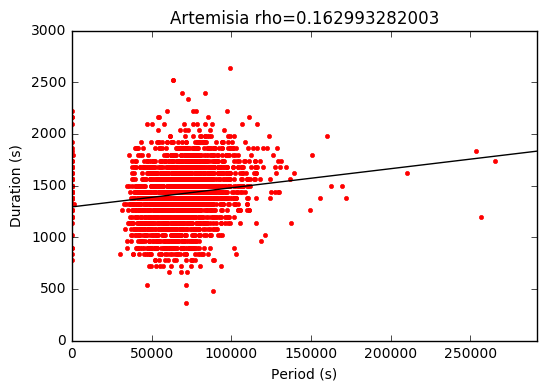

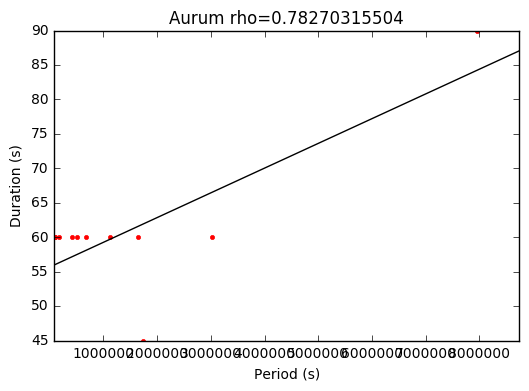

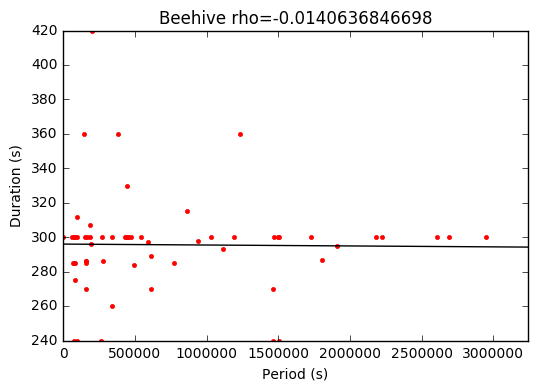

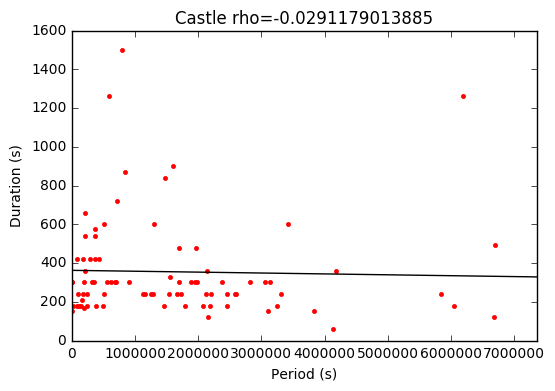

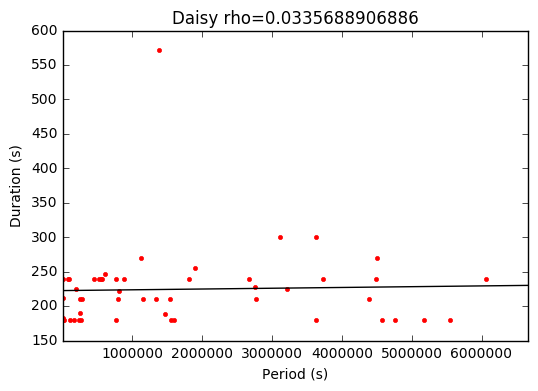

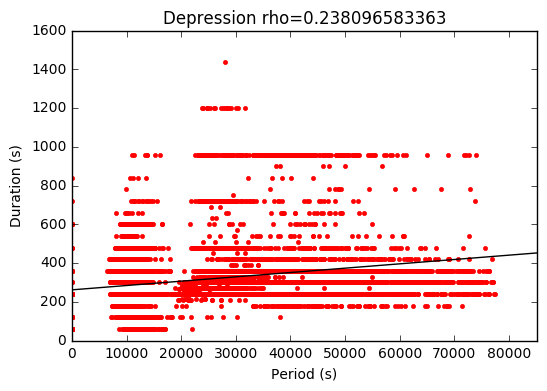

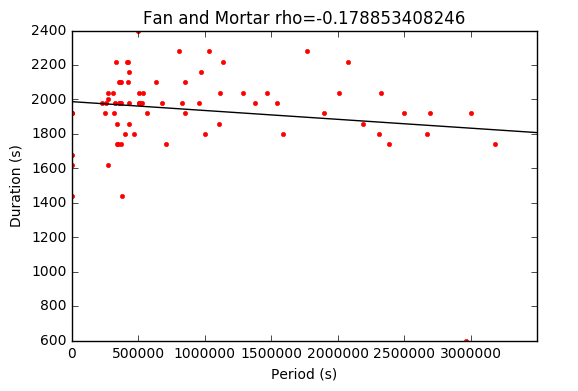

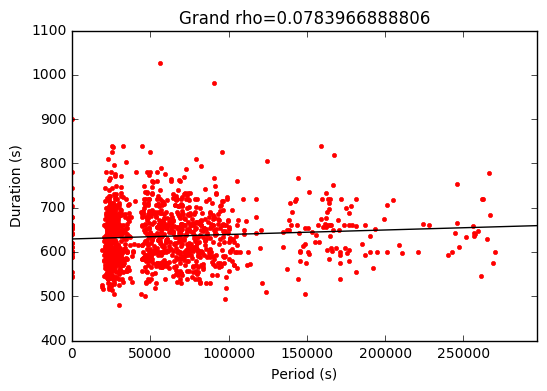

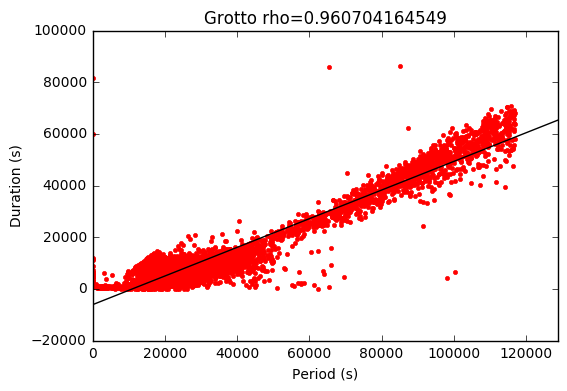

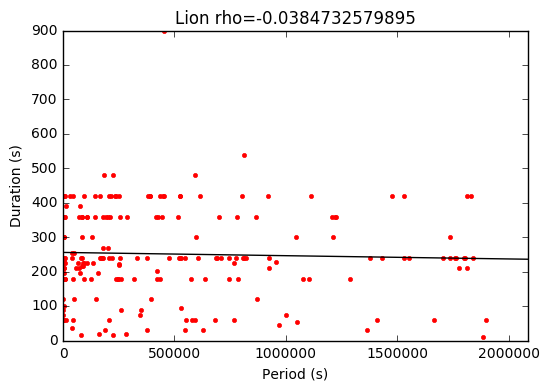

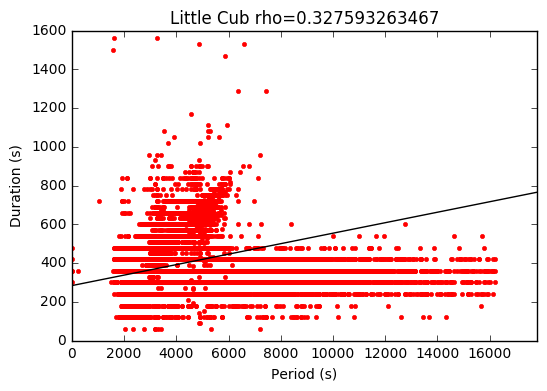

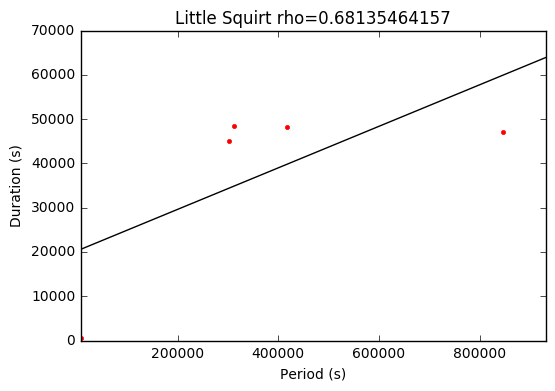

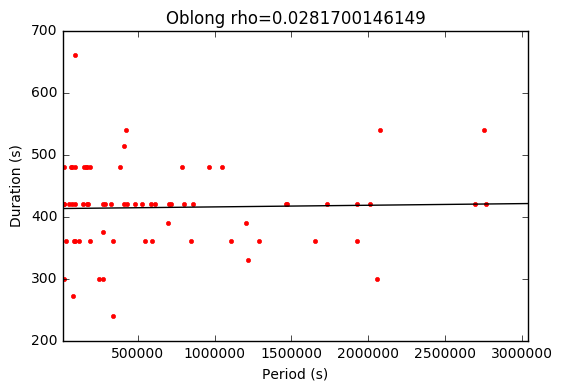

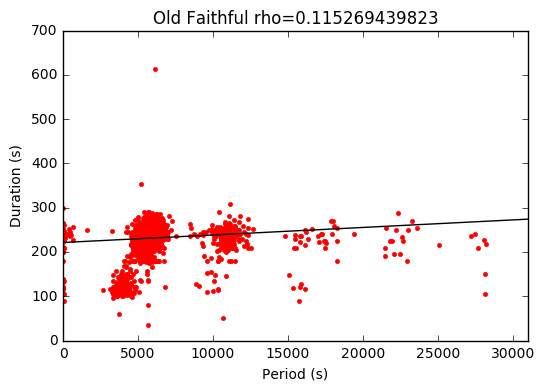

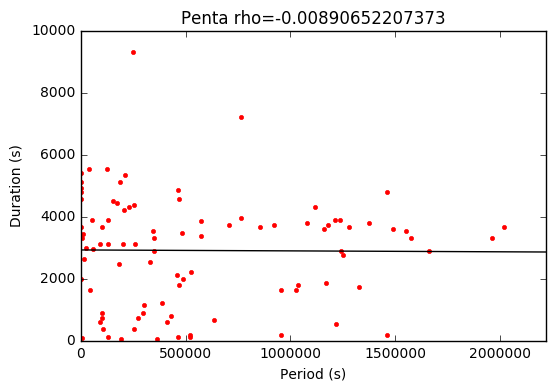

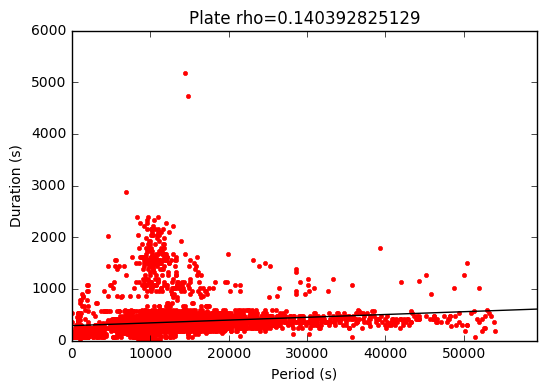

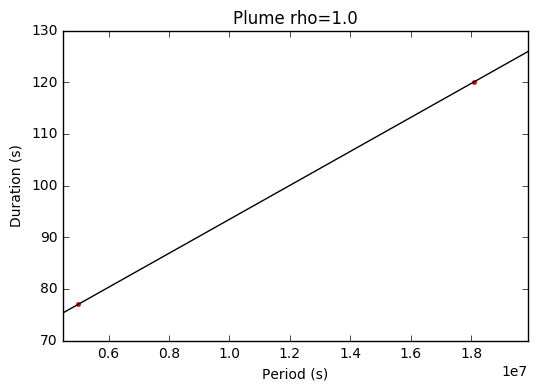

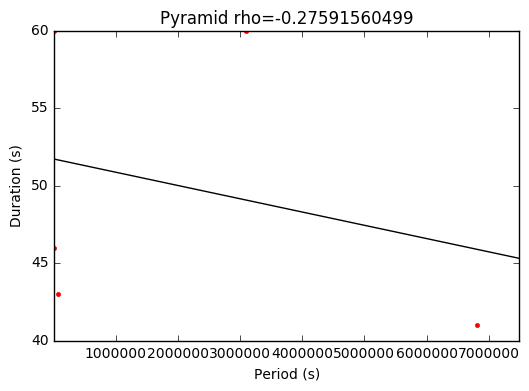

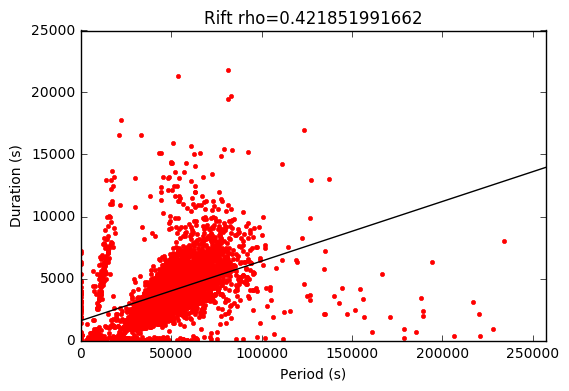

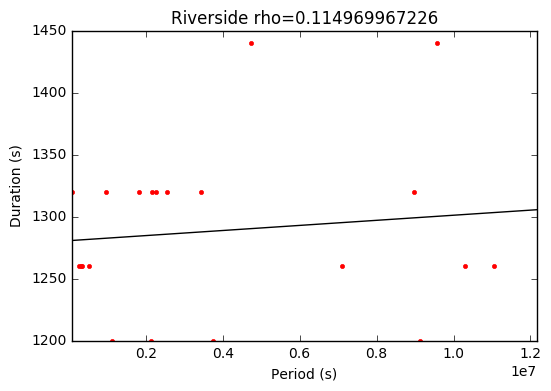

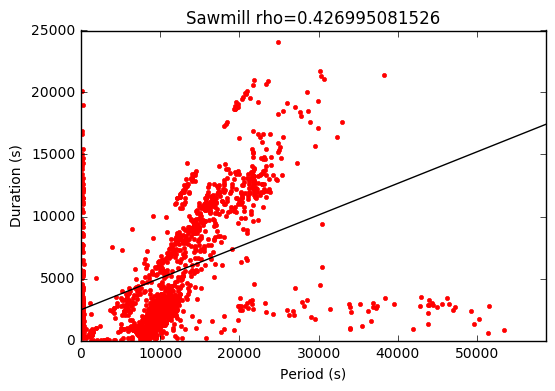

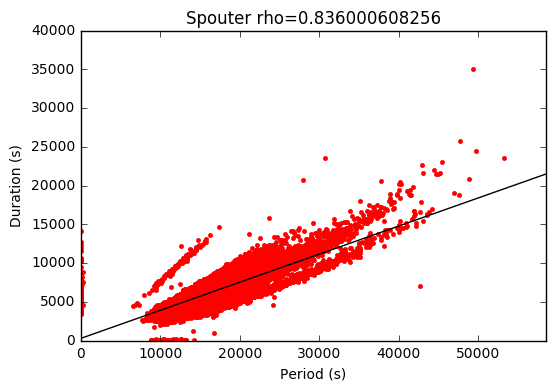

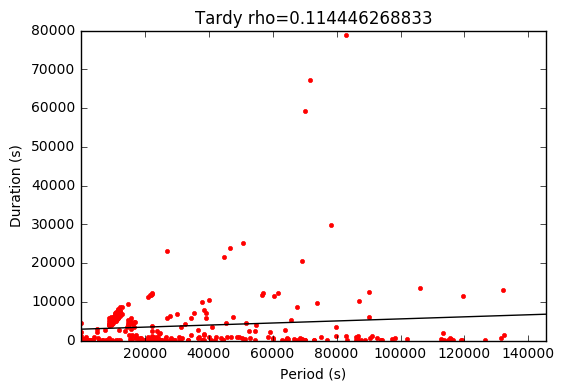

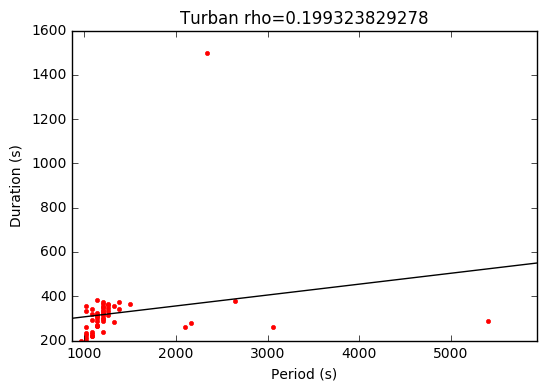

In [277]:
#for any observation if at least one is electronic
for i in range(len(enamesl1)):
    plot_lin_reg_dp(df,enamesl1[i])

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


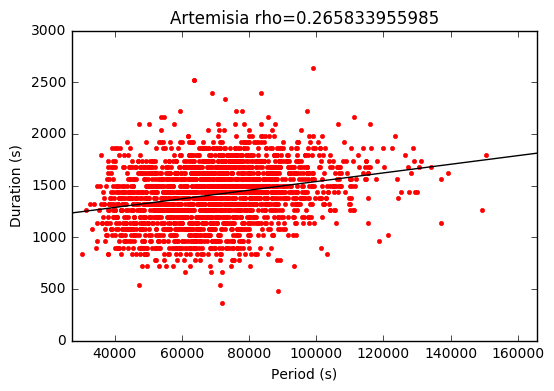

Not enough data for geyser Aurum


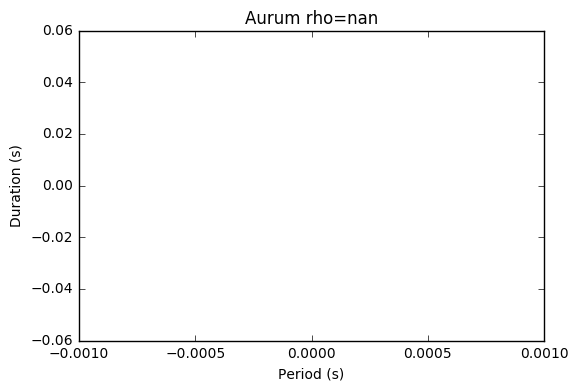

Not enough data for geyser Beehive


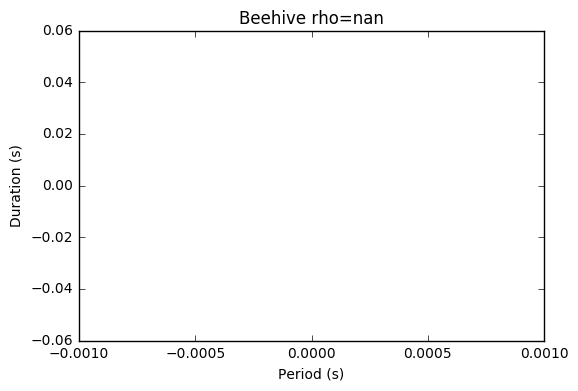

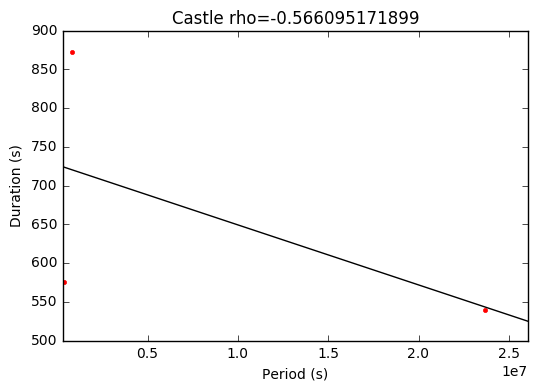

/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


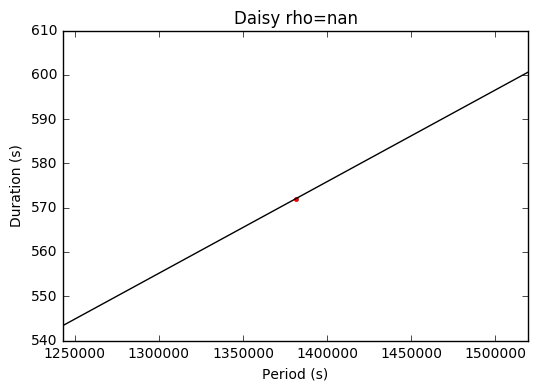

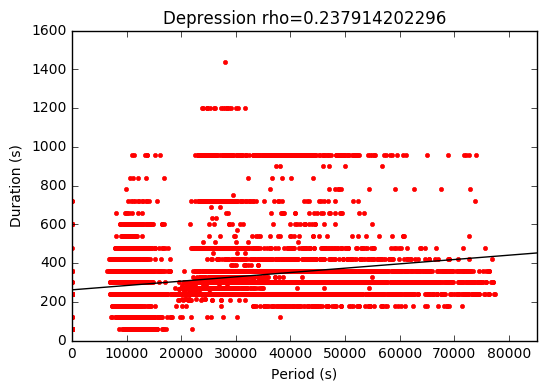

Not enough data for geyser Fan and Mortar


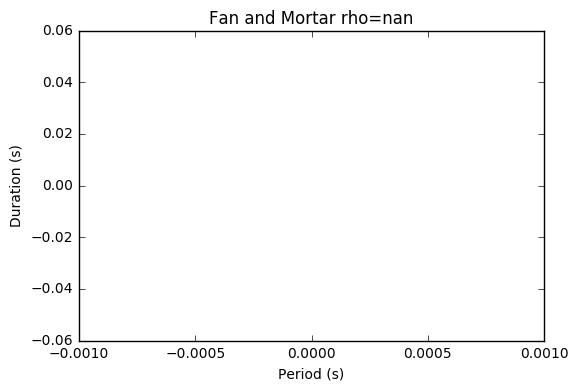

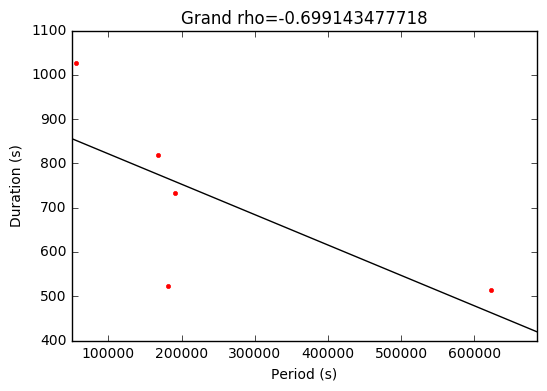

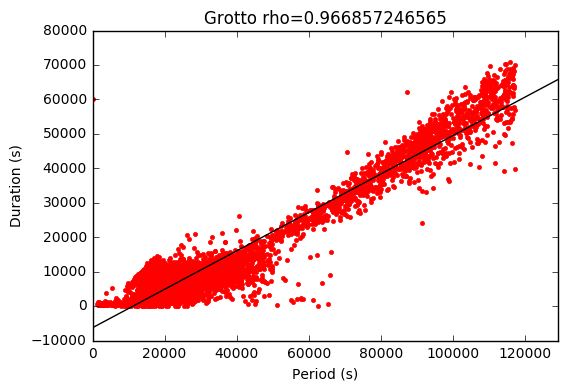

Not enough data for geyser Lion


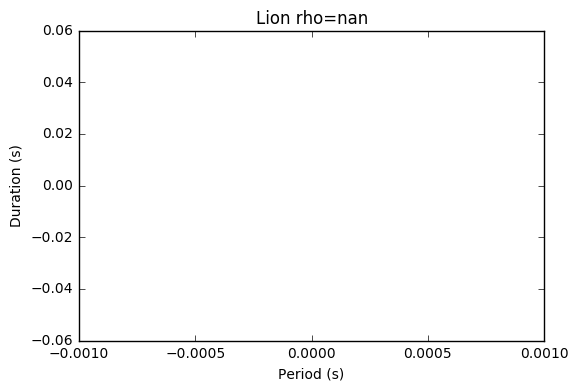

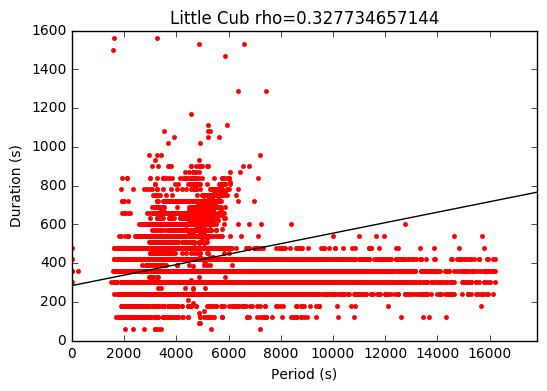

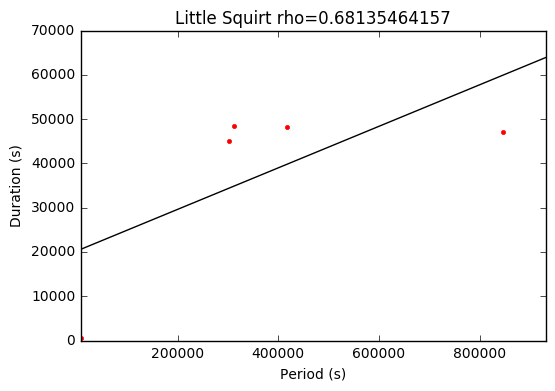

Not enough data for geyser Oblong


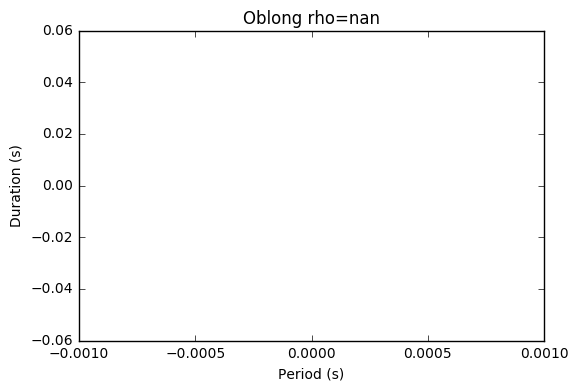

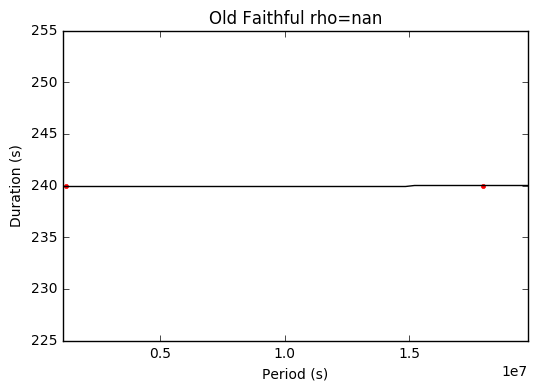

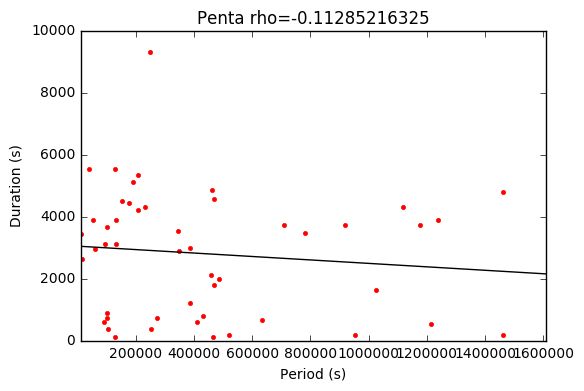

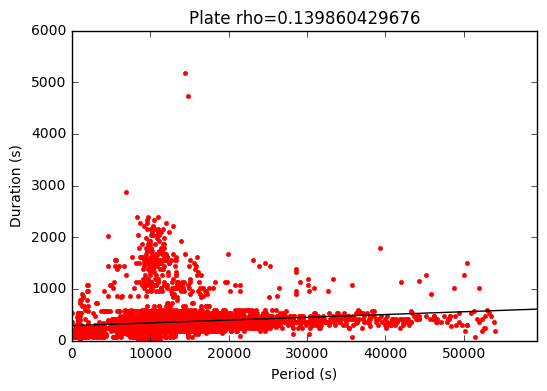

Not enough data for geyser Plume


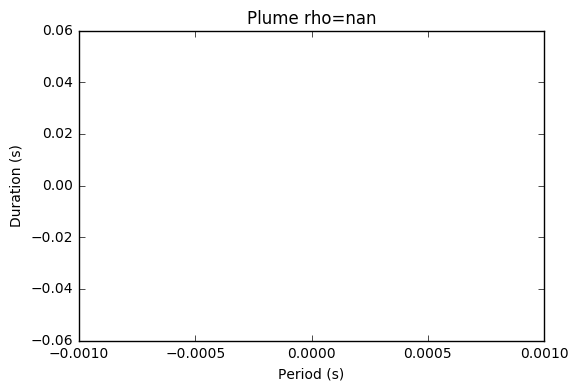

Not enough data for geyser Pyramid


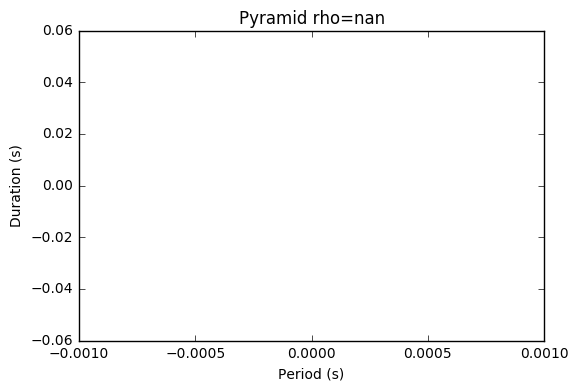

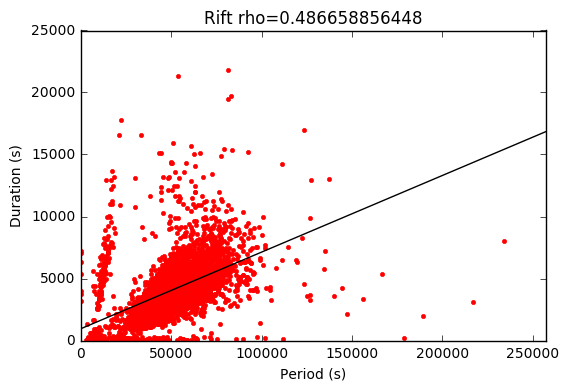

Not enough data for geyser Riverside


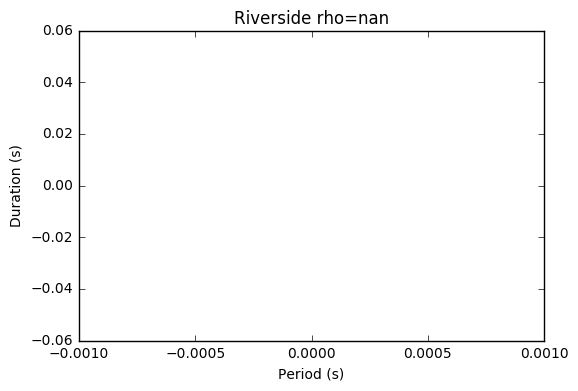

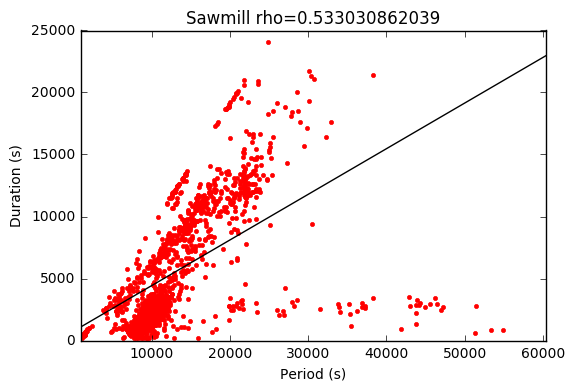

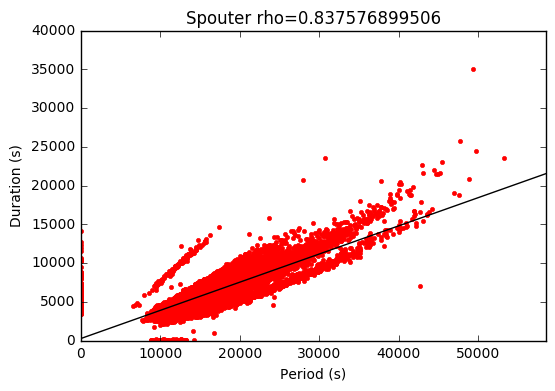

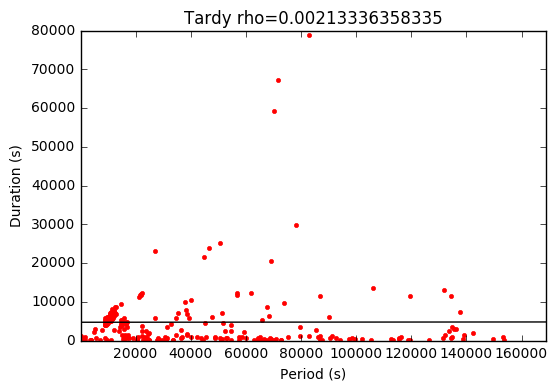

Not enough data for geyser Turban


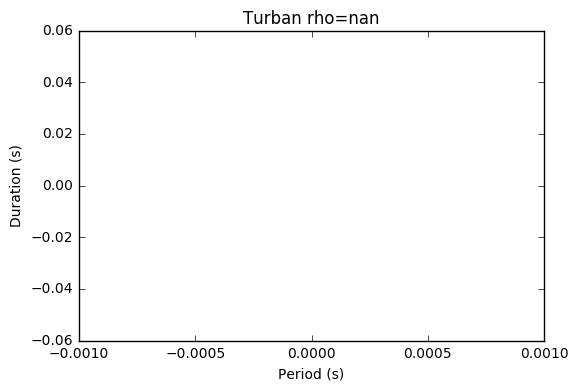

In [282]:
#for electronic observations only
for i in range(len(enamesl1)):
    plot_lin_reg_dp(dfe,enamesl1[i])

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


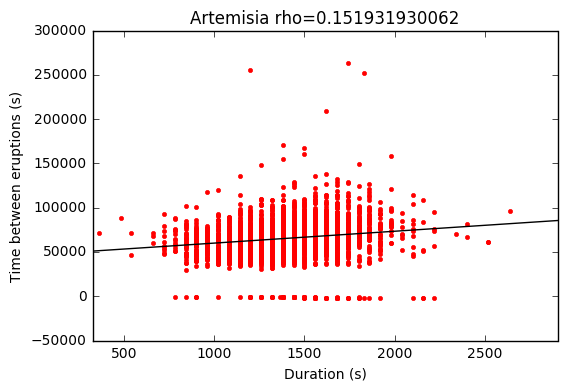

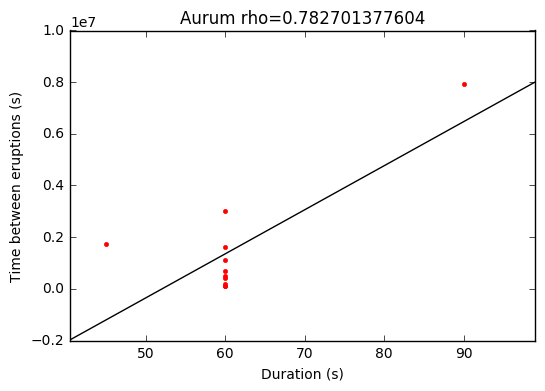

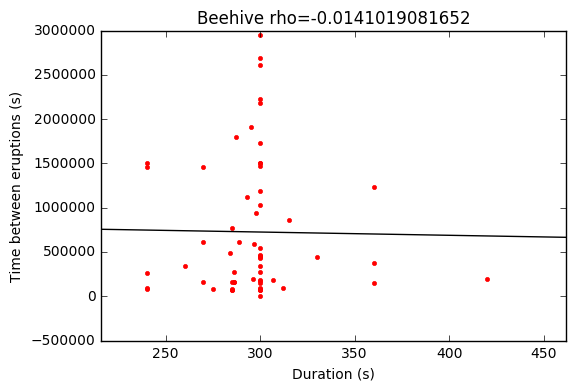

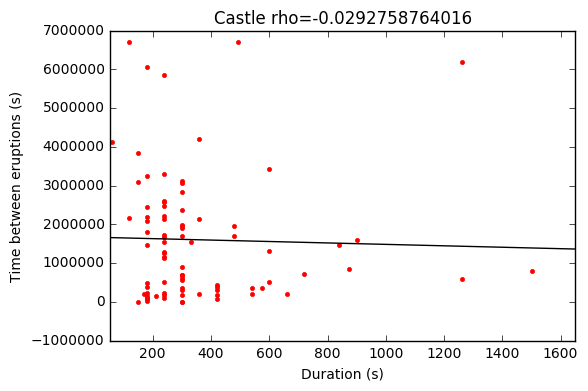

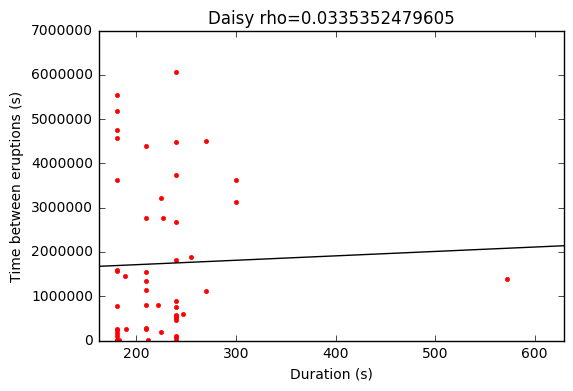

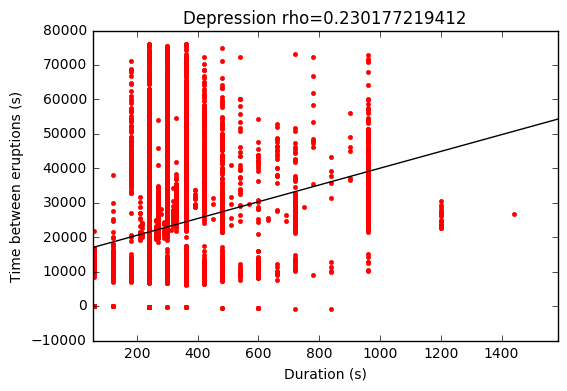

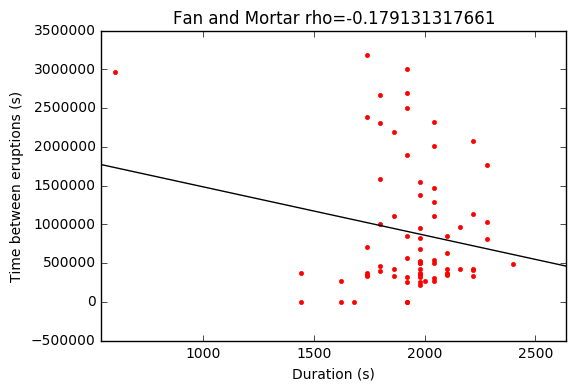

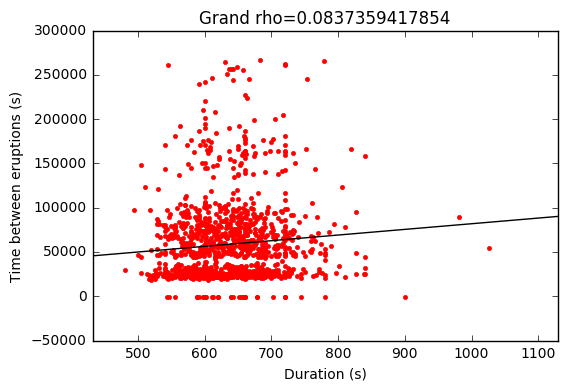

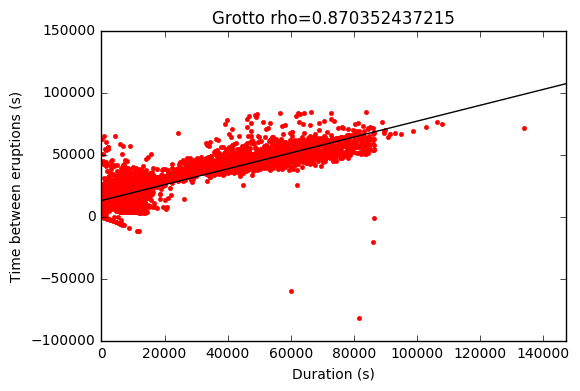

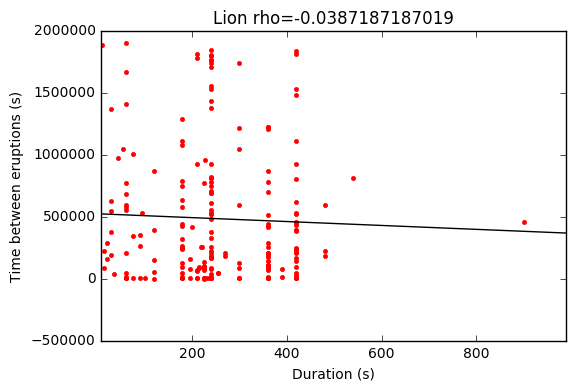

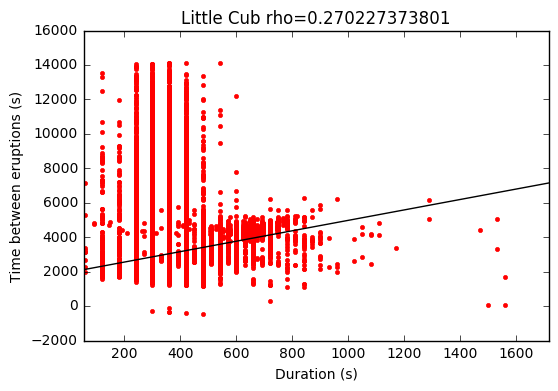

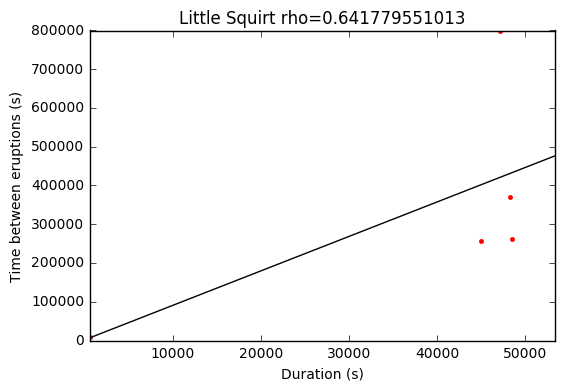

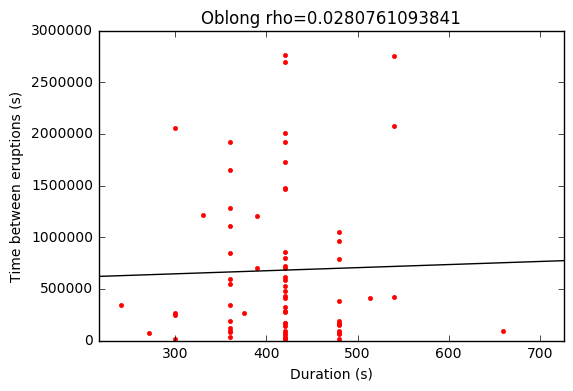

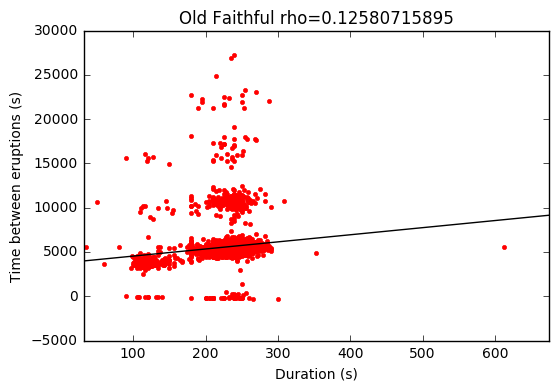

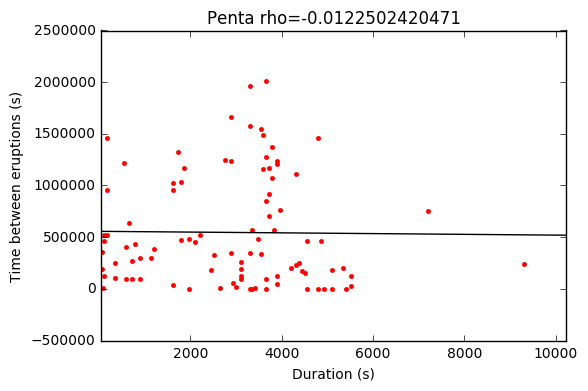

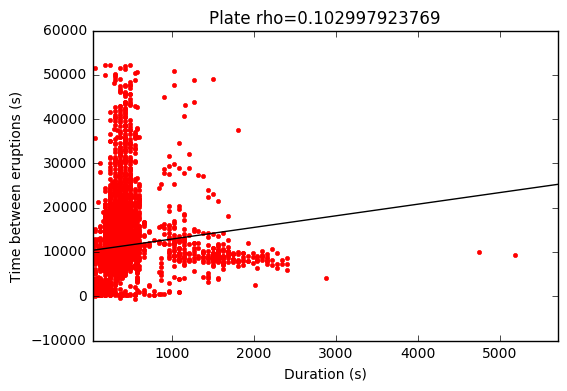

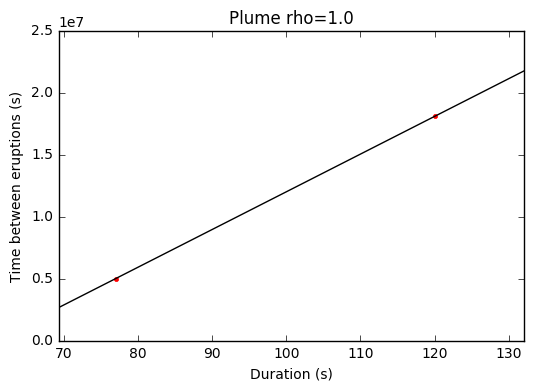

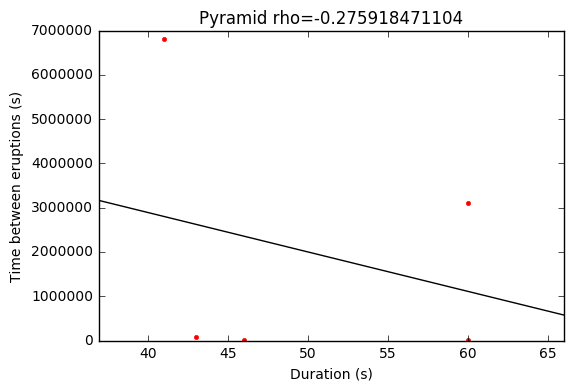

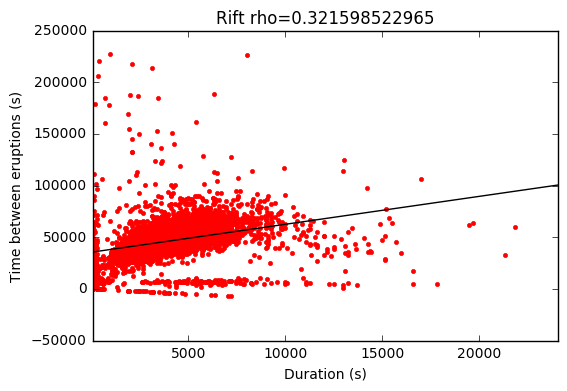

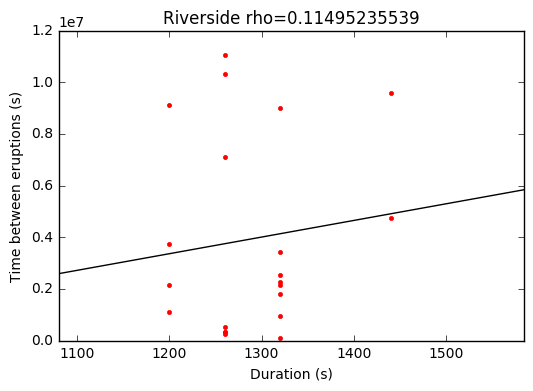

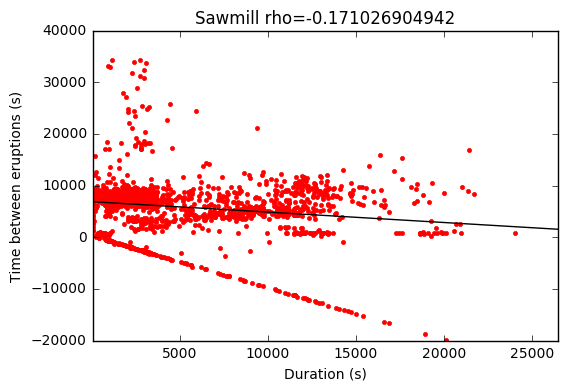

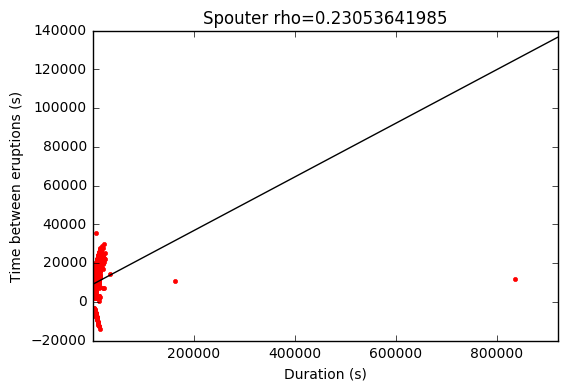

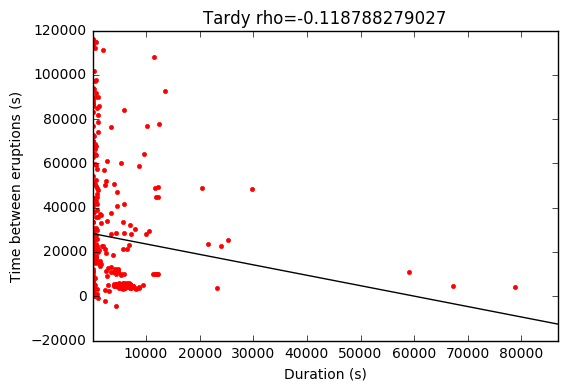

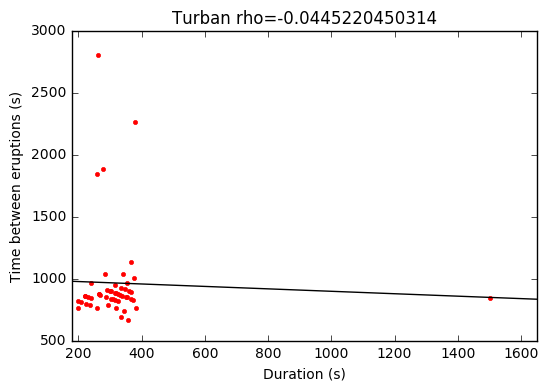

In [290]:
#next start time vs. duration, all
for i in range(len(enamesl1)):
    plot_lin_reg_dns(df,enamesl1[i])

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


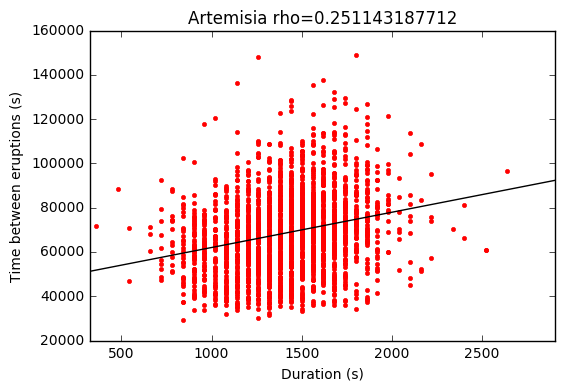

Not enough data for geyser Aurum


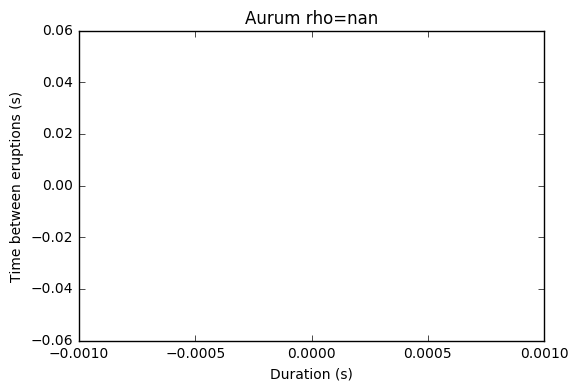

Not enough data for geyser Beehive


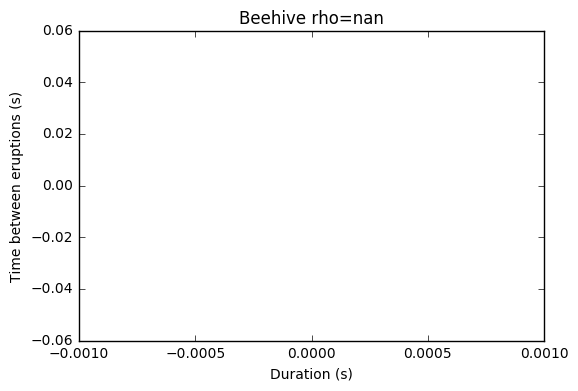

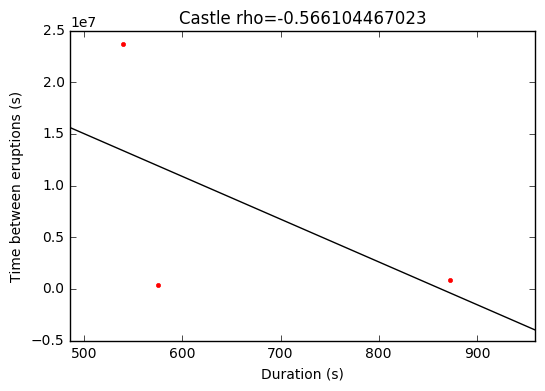

/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


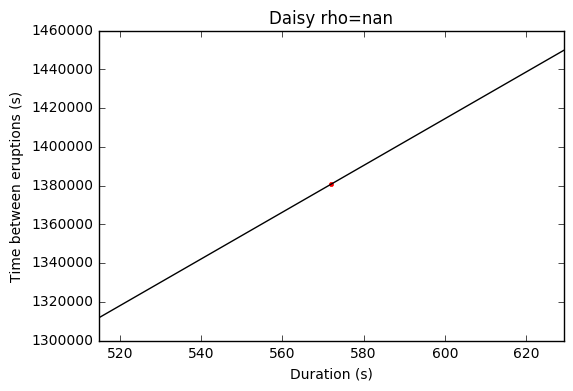

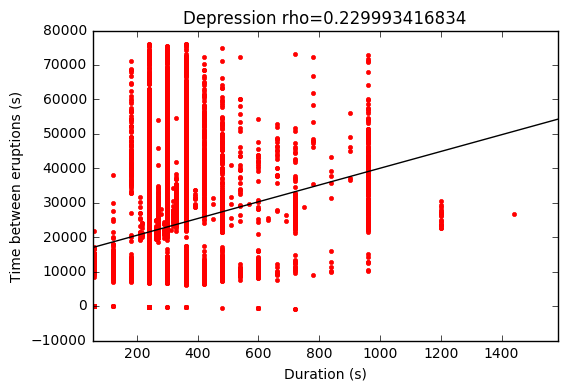

Not enough data for geyser Fan and Mortar


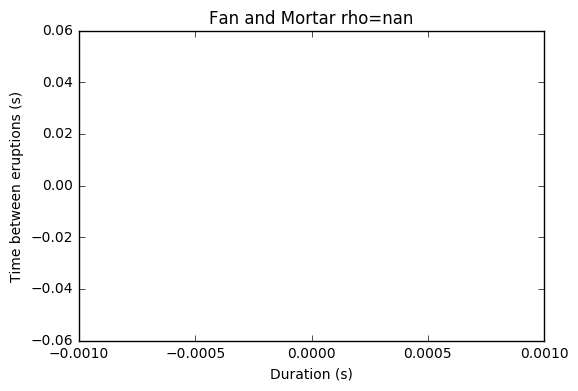

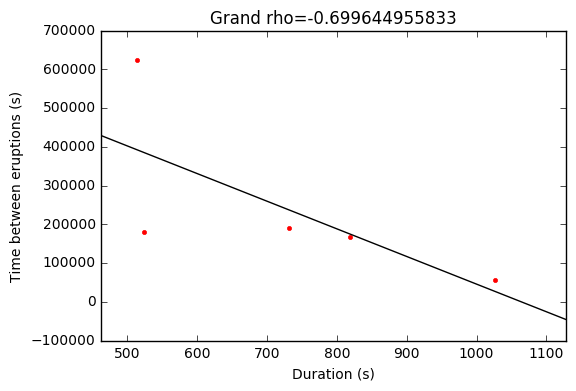

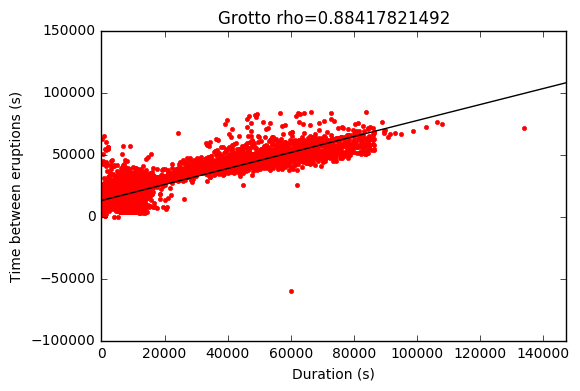

Not enough data for geyser Lion


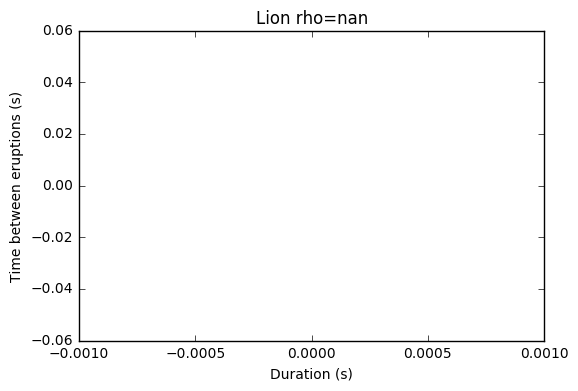

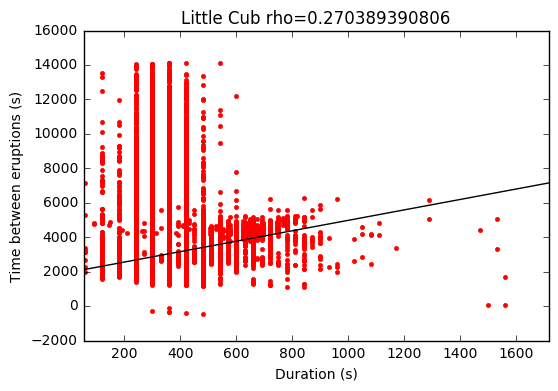

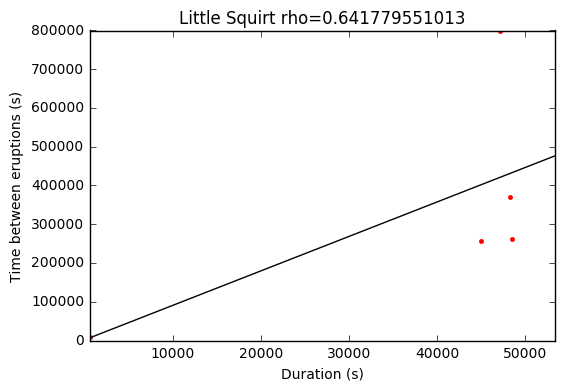

Not enough data for geyser Oblong


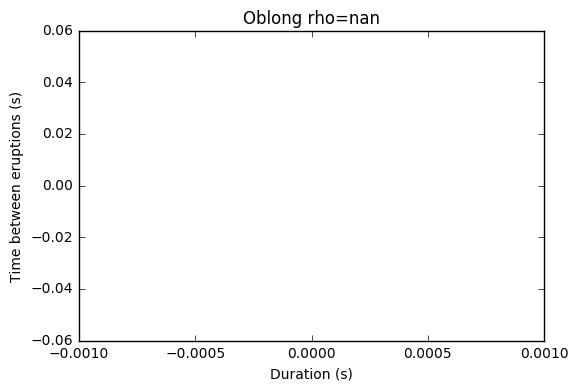

/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


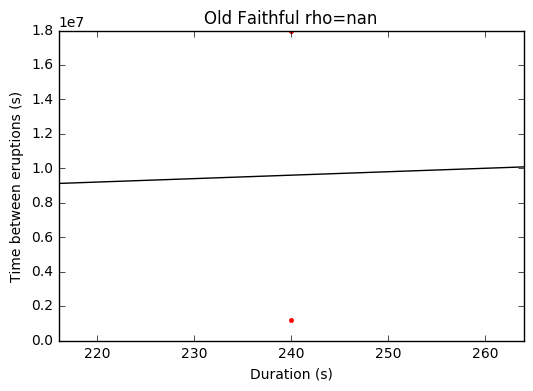

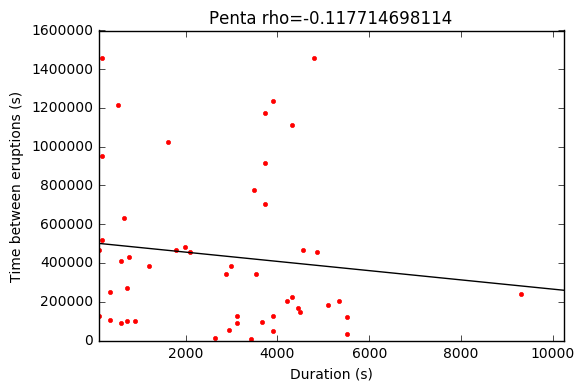

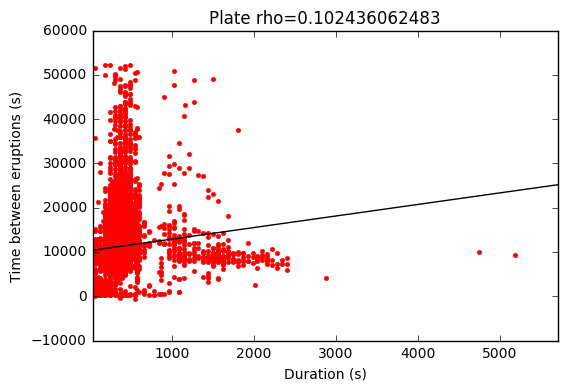

Not enough data for geyser Plume


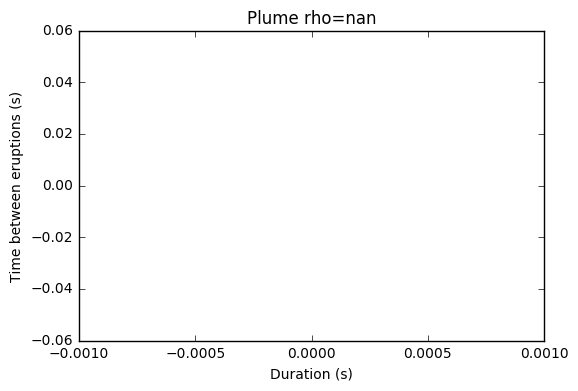

Not enough data for geyser Pyramid


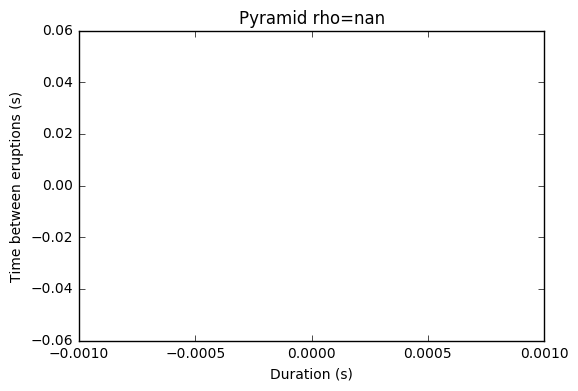

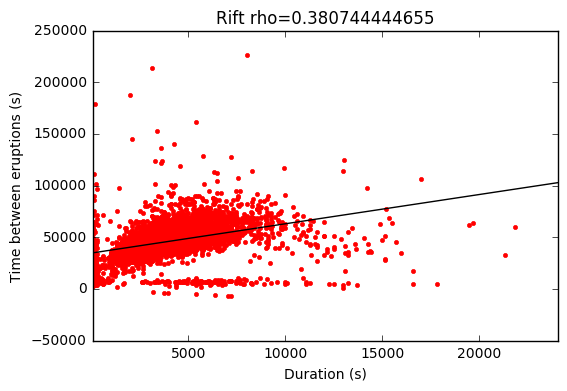

Not enough data for geyser Riverside


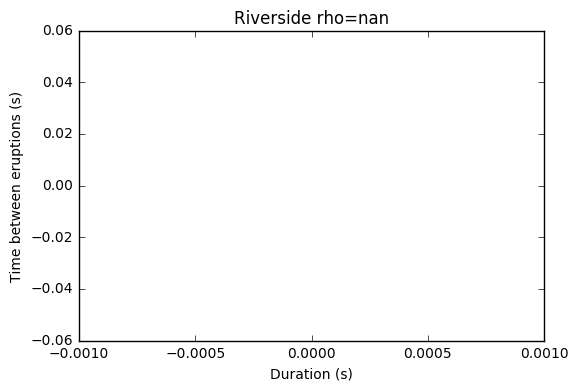

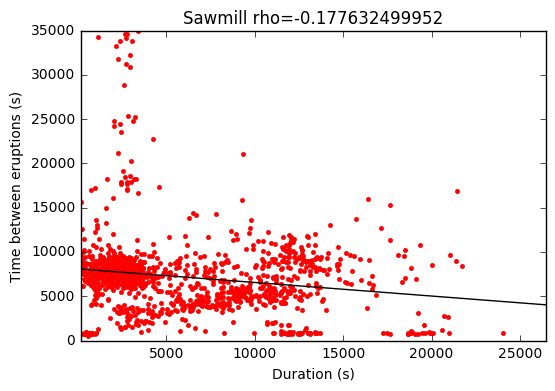

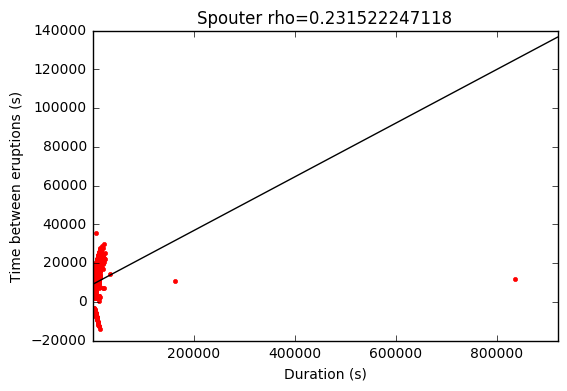

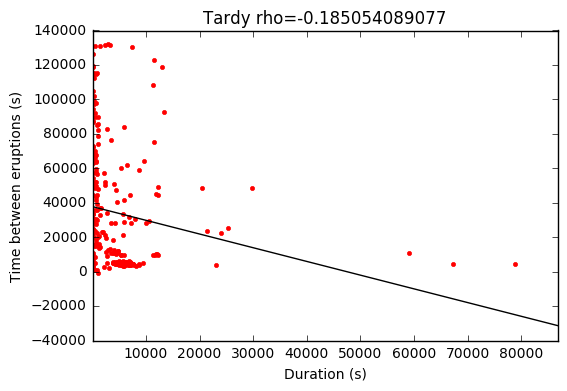

Not enough data for geyser Turban


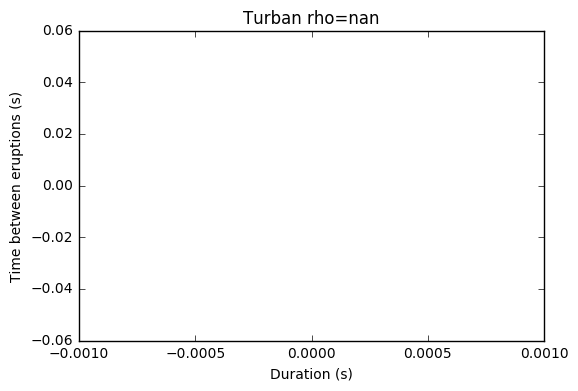

In [291]:
#next start time vs. duration, electronic only
for i in range(len(enamesl1)):
    plot_lin_reg_dns(dfe,enamesl1[i])

In [152]:
cnames=df1['name'].values
cnamesl=cnames.tolist()

In [153]:
cnamesl

['Anemone-Big',
 'Anemone-Little',
 'Artemisia',
 'Atomizer',
 'Aurum',
 'Beehive',
 "Beehive's Indicator",
 'Bulger',
 "Bulger's Hole",
 'Castle',
 'Churn',
 'Cliff',
 'Daisy',
 'Depression',
 'Dome',
 'Fan and Mortar',
 'Grand',
 'Grotto',
 'Grotto Fountain',
 'Jewel',
 'Lion',
 'Little Brother',
 'Little Cub',
 'Little Squirt',
 'Oblong',
 'Old Faithful',
 'Old Tardy',
 'Penta',
 'Percolator',
 'Plate',
 'Plume',
 'Pump',
 'Pyramid',
 'Rift',
 'Riverside',
 'Rocket',
 'Round Spring-Geyser',
 'Rusty',
 'Sawmill',
 'Solitary',
 'South Grotto Fountain',
 'Spa',
 'Spasmodic',
 'Split Cone',
 'Sponge',
 'Spouter',
 'Sprinkler',
 'Sputnik',
 'Tardy',
 'Terra Cotta-A',
 'Terra Cotta-B',
 'Terra Cotta-C',
 'The Dwarfs',
 "Tilt's Baby",
 'Turban',
 'Uncertain',
 'Vent',
 'West Triplet']

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


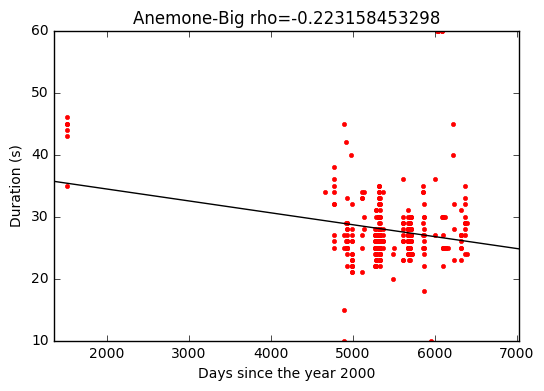

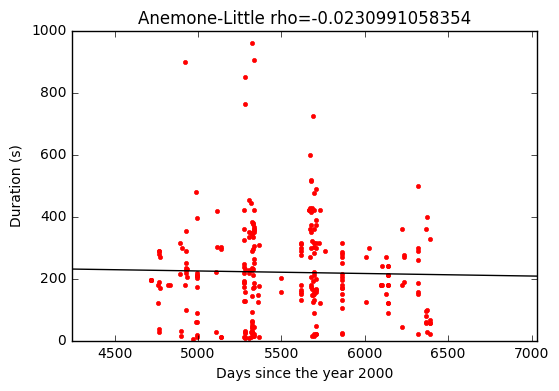

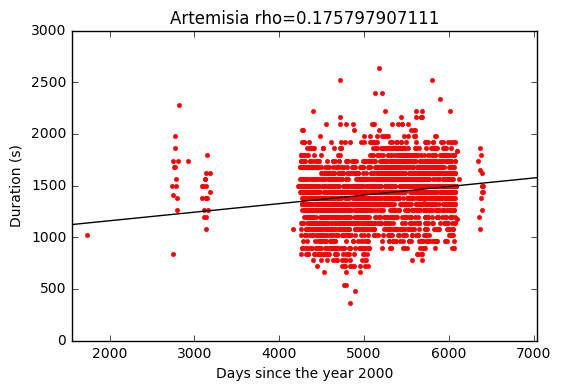

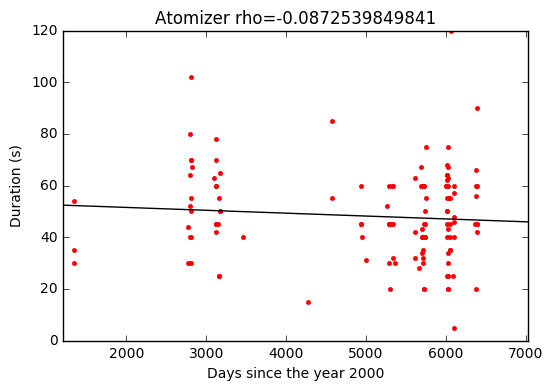

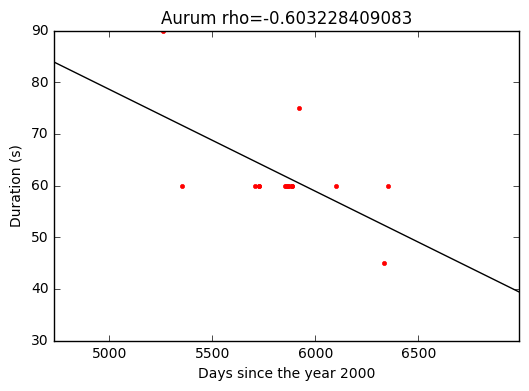

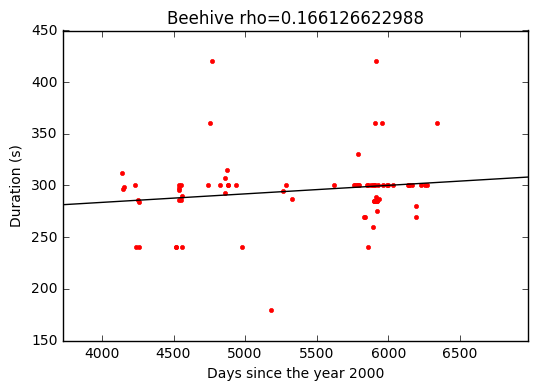

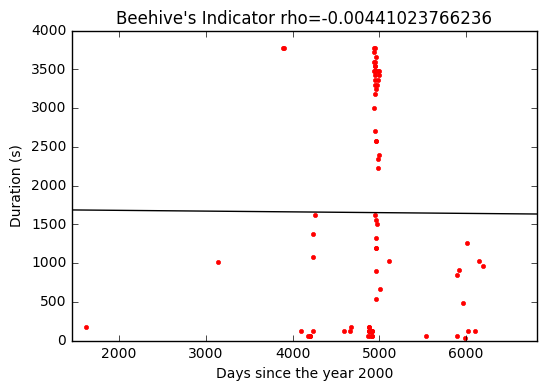

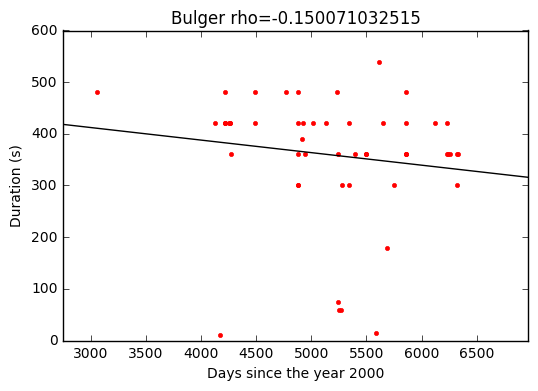

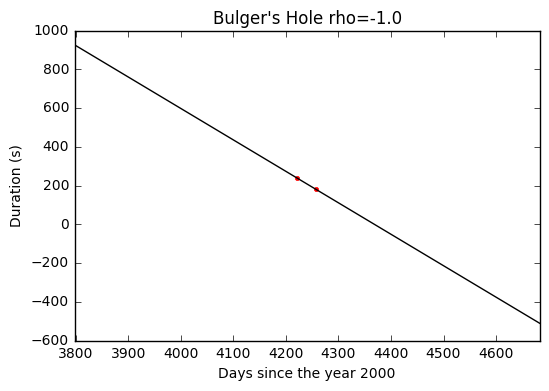

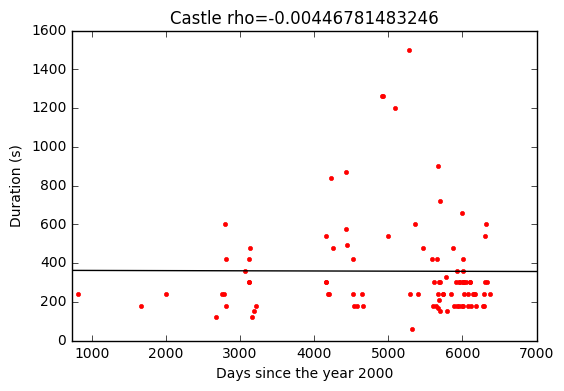

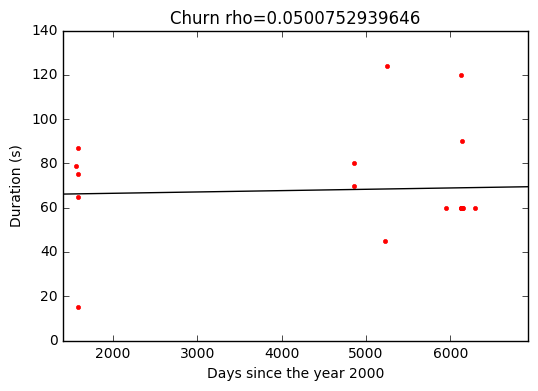

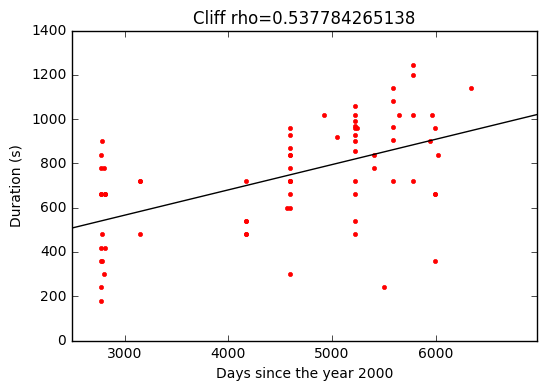

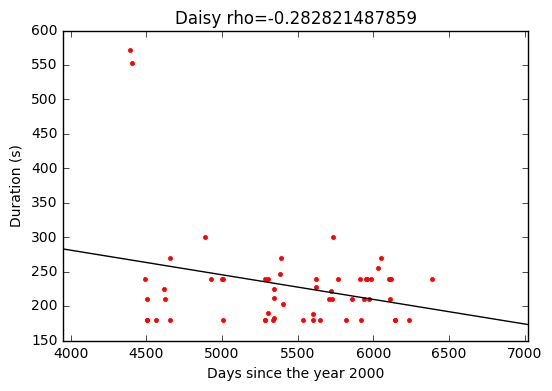

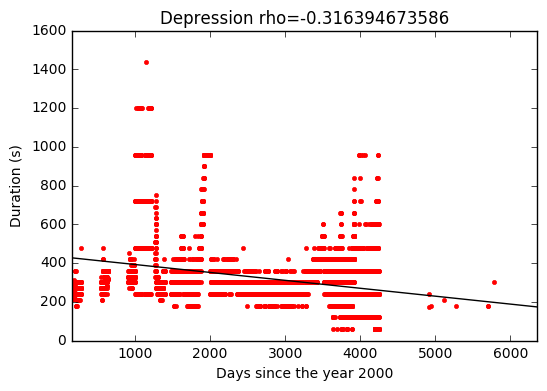

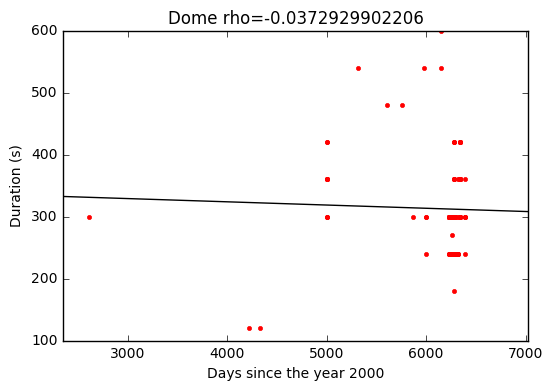

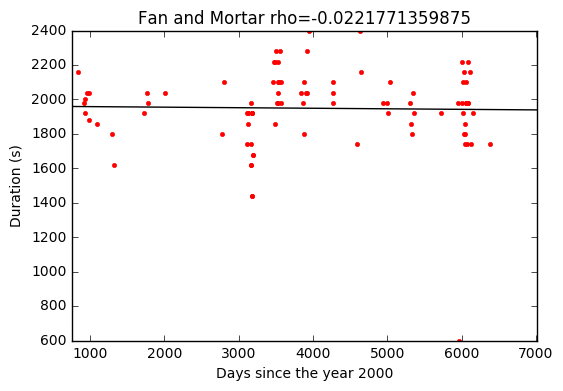

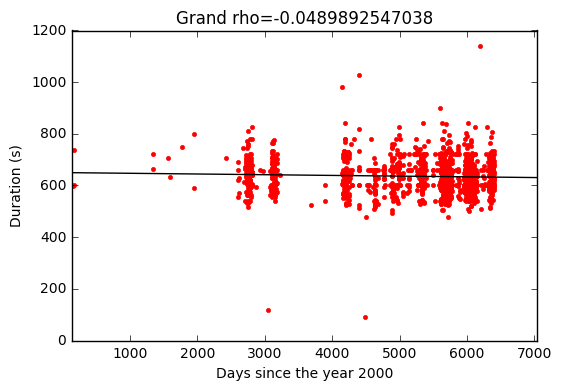

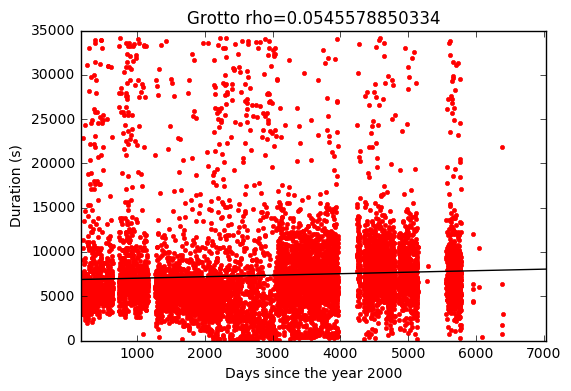

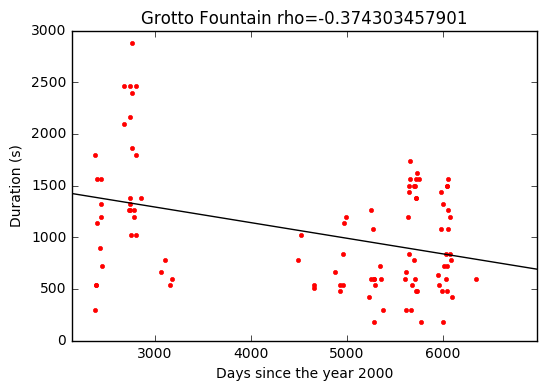

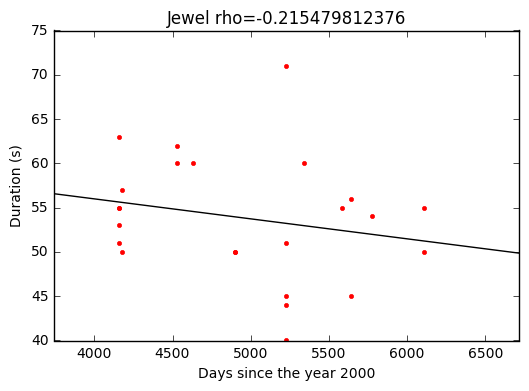

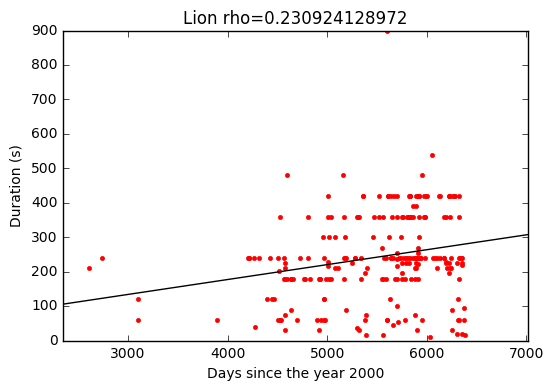

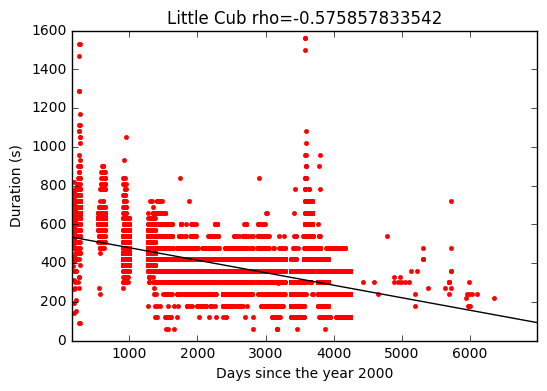

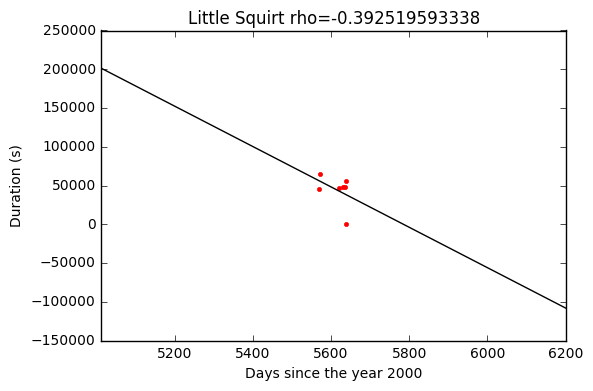

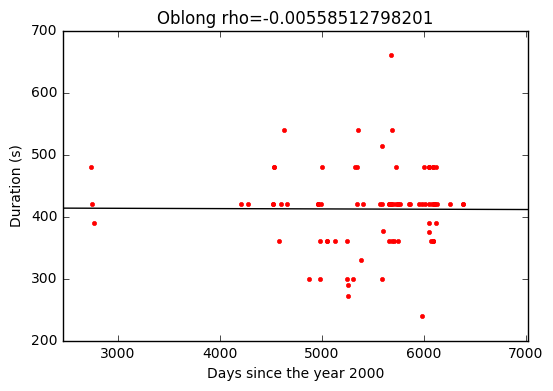

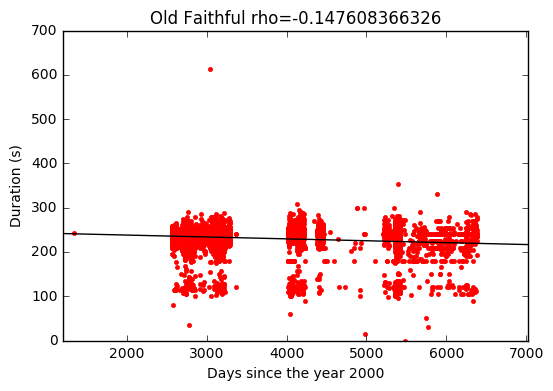

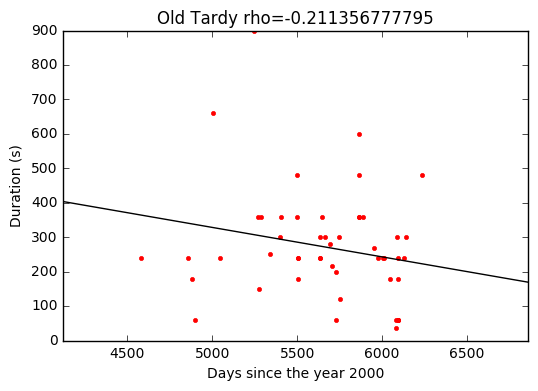

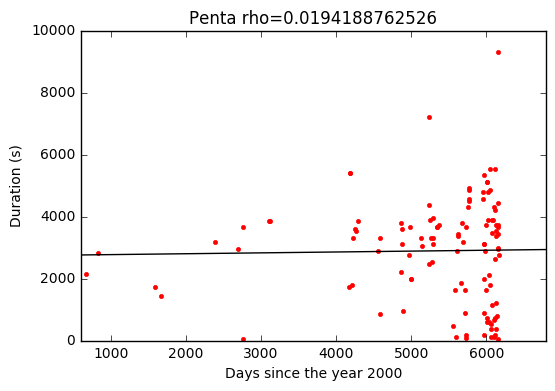

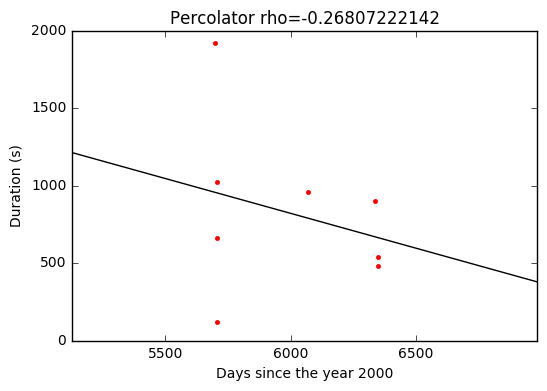

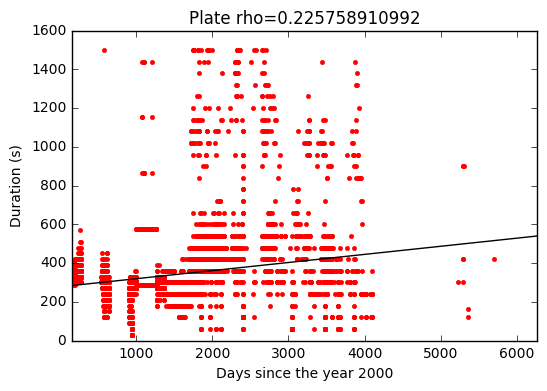

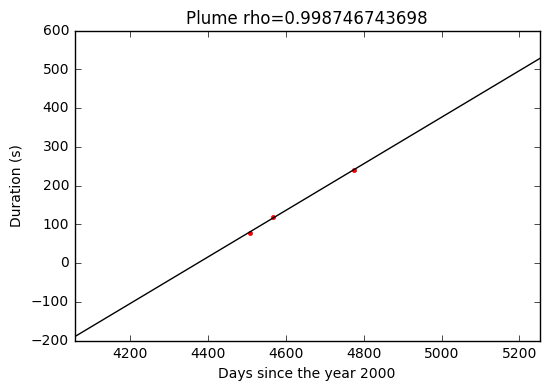

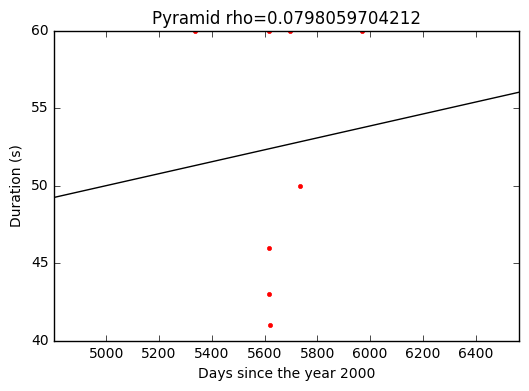

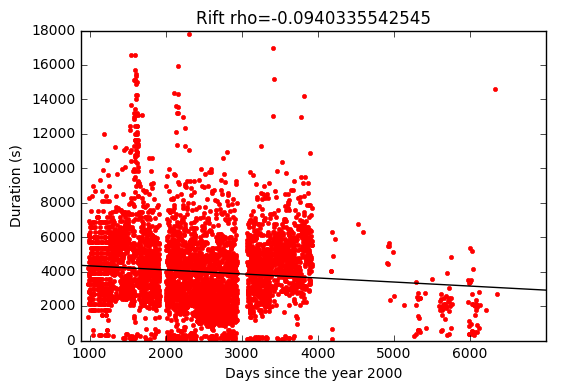

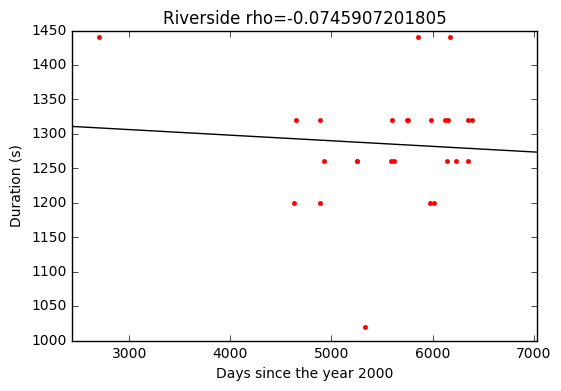

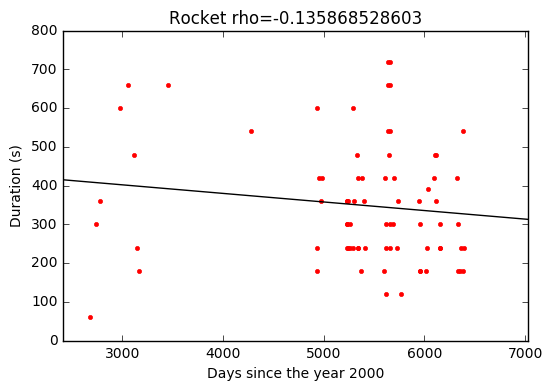

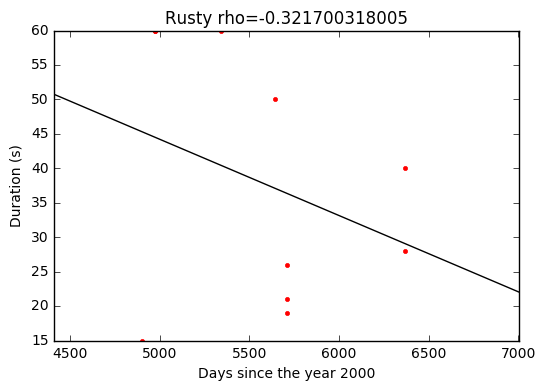

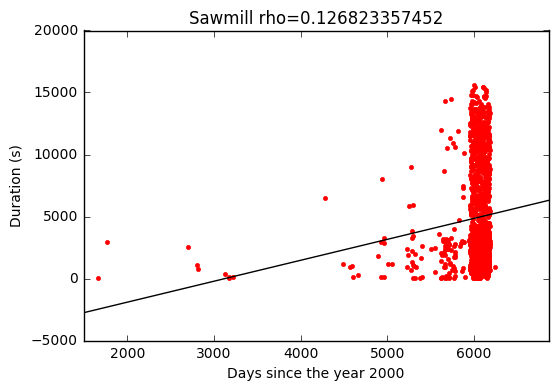

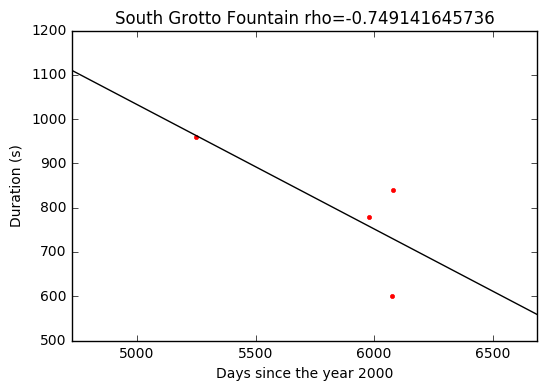

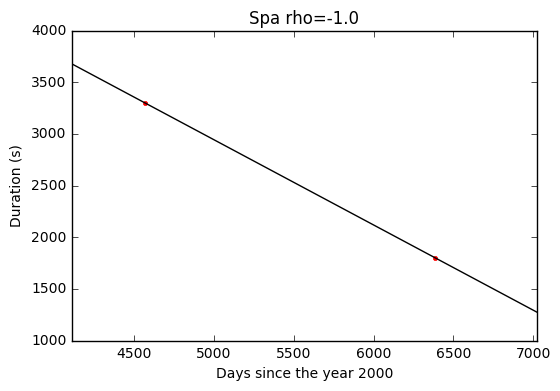

/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


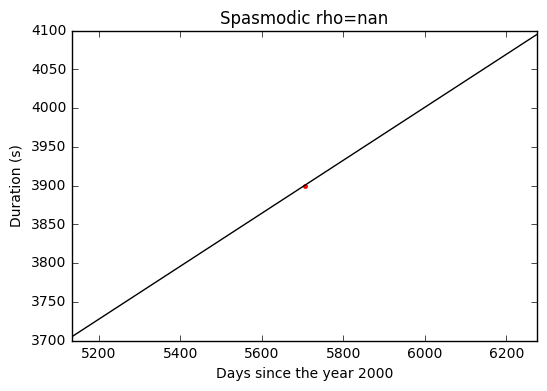

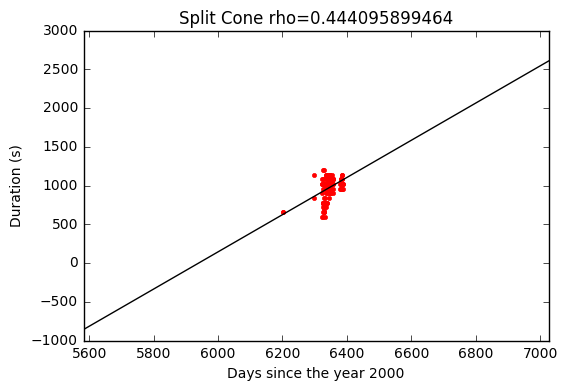

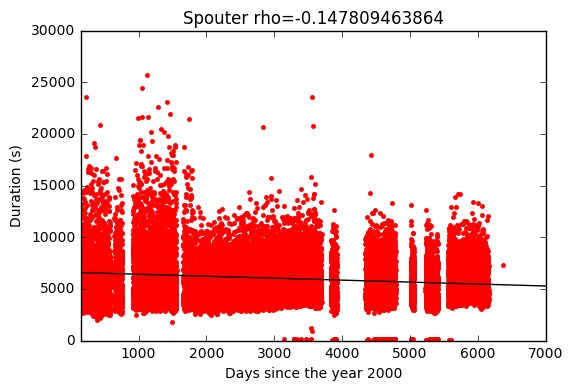

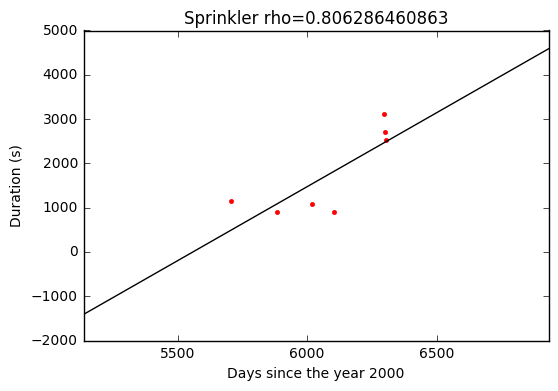

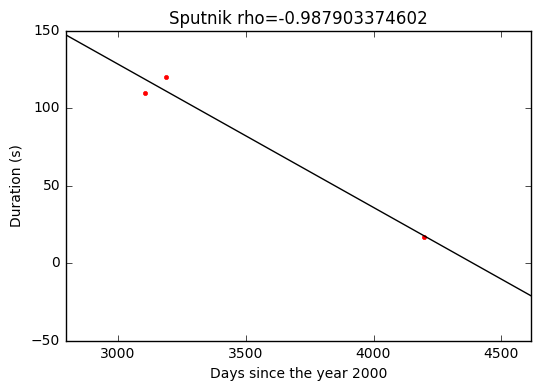

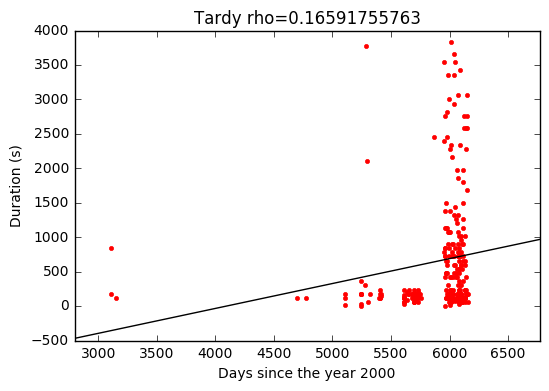

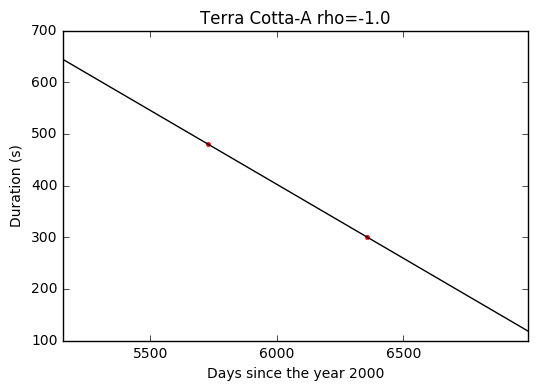

/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


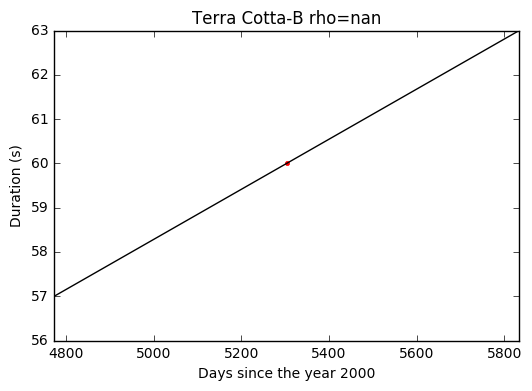

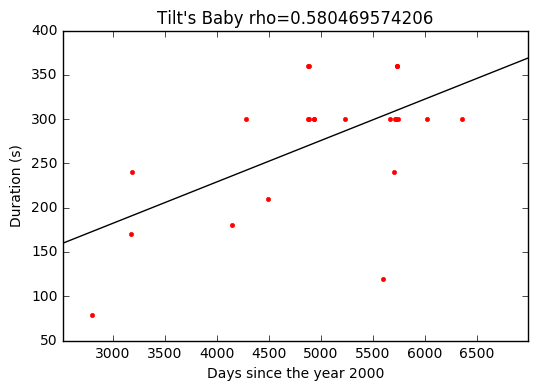

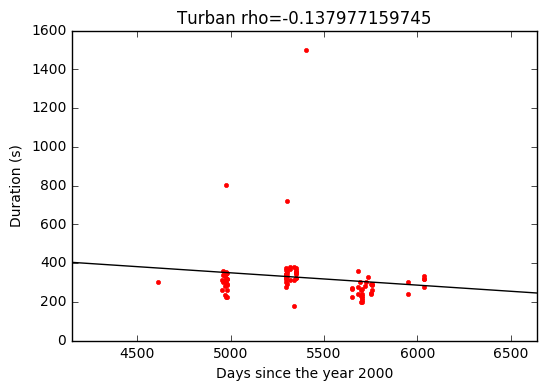

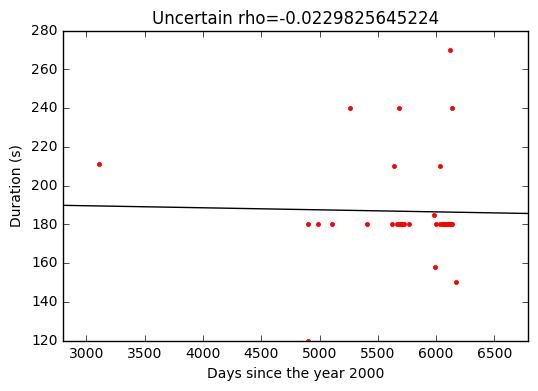

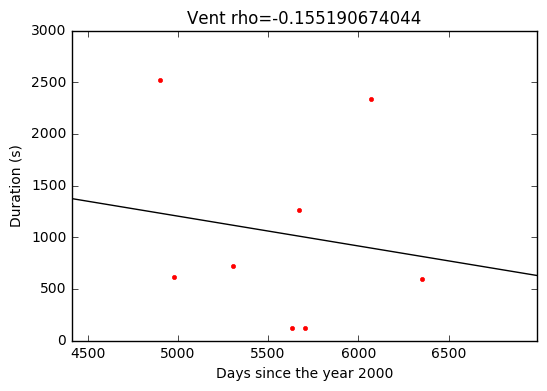

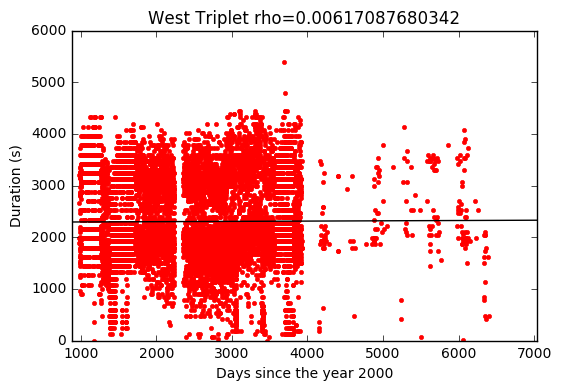

In [302]:
for i in range(len(cnamesl)):
    plot_d_vs_st(df,cnamesl[i])

In [233]:
df.columns

Index(['A', 'E', 'comment', 'duration', 'durationMod', 'durationRes',
       'durationSec', 'entrant', 'entrantID', 'eruptionID', 'exact', 'geyser',
       'geyserID', 'grandCode.afterbursts', 'grandCode.bursts',
       'grandCode.delay', 'grandCode.end', 'grandCode.pound', 'grandCode.star',
       'grandCode.start', 'hasSeconds', 'ie', 'ini', 'maj', 'min', 'ns',
       'observer', 'primaryID', 'q', 'time', 'timeEntered', 'timeUpdated',
       'timezone', 'wc'],
      dtype='object')

In [305]:
period,duration=get_period_duration(df,name)

/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [306]:
period

array([ 18720.,  24720.,  12240., ...,   9840.,  11700.,  15540.])

In [307]:
duration

array([5280, 7560, 3240, ..., 3960, 4860, 7200])

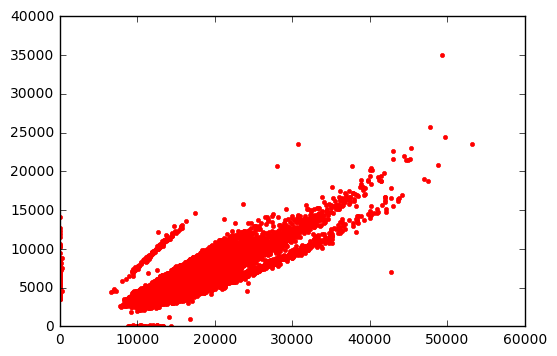

In [310]:
plt.plot(period,duration,'r.')
plt.show()

In [312]:
#combine our databases for each year
df0=df0a
df0=df0.append(df0b)

df1=df1a
df1=df1.append(df1b)

df2=df2a
df2=df2.append(df2b)

df3=df3a
df3=df3.append(df3b)

df4=df4a
df4=df4.append(df4b)

df5=df5a
df5=df5.append(df4b)

df6=df6a
df6=df6.append(df6b)

df7=df7a
df7=df7.append([df7b,df7c])

df8=df8a
df8=df8.append([df8b,df8c])

df9=df9a
df9=df9.append(df9b)

df10=df10a
df10=df10.append(df10b)

df11=df11a
df11=df11.append([df11b,df11c,df11d])

df12=df12a
df12=df12.append([df12b,df12c])

df13=df13a
df13=df13.append(df13b)

df14=df14a
df14=df14.append([df14b,df14c])

df15=df15a
df15=df15.append(df15b)

df16=df16a
df16=df16.append(df16b)

df17=df17a




In [315]:
name='Grotto'
period0,duration0=get_period_duration(df0,name)
period1,duration1=get_period_duration(df1,name)
period2,duration2=get_period_duration(df2,name)
period3,duration3=get_period_duration(df3,name)
period4,duration4=get_period_duration(df4,name)
period5,duration5=get_period_duration(df5,name)
period6,duration6=get_period_duration(df6,name)
period7,duration7=get_period_duration(df7,name)
period8,duration8=get_period_duration(df8,name)
period9,duration9=get_period_duration(df9,name)
period10,duration10=get_period_duration(df10,name)
period11,duration11=get_period_duration(df11,name)
period12,duration12=get_period_duration(df12,name)
period13,duration13=get_period_duration(df13,name)
period14,duration14=get_period_duration(df14,name)
period15,duration15=get_period_duration(df15,name)
period16,duration16=get_period_duration(df16,name)
period17,duration17=get_period_duration(df17,name)


/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


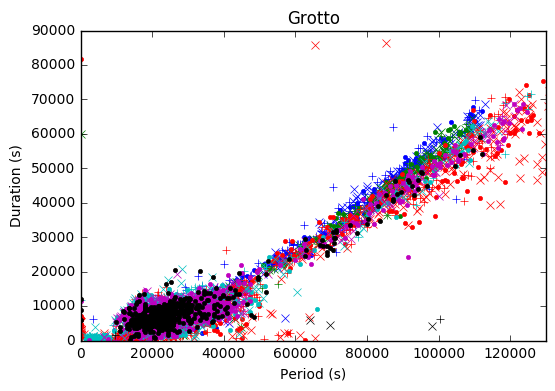

In [336]:
xmin=0
xmax=130000
plt.plot(period0,duration0,'b.',period1,duration1,'bx',period2,duration2,'b+',
         period3,duration3,'g.',period4,duration4,'gx',period5,duration5,'g+',
        period6,duration6,'r.',period7,duration7,'rx',period8,duration8,'r+',
        period9,duration9,'c.',period10,duration10,'cx',period11,duration11,'c+',
        period12,duration12,'m.',period13,duration13,'mx',period14,duration14,'m+',
        period15,duration15,'k.',period16,duration16,'kx',period17,duration17,'k+')
#pylab.ylim([0,2000])
pylab.xlim([xmin,xmax])
pylab.xlabel('Period (s)')
pylab.ylabel('Duration (s)')
pylab.title(name)
plt.show()

In [337]:
name='Spouter'
period0,duration0=get_period_duration(df0,name)
period1,duration1=get_period_duration(df1,name)
period2,duration2=get_period_duration(df2,name)
period3,duration3=get_period_duration(df3,name)
period4,duration4=get_period_duration(df4,name)
period5,duration5=get_period_duration(df5,name)
period6,duration6=get_period_duration(df6,name)
period7,duration7=get_period_duration(df7,name)
period8,duration8=get_period_duration(df8,name)
period9,duration9=get_period_duration(df9,name)
period10,duration10=get_period_duration(df10,name)
period11,duration11=get_period_duration(df11,name)
period12,duration12=get_period_duration(df12,name)
period13,duration13=get_period_duration(df13,name)
period14,duration14=get_period_duration(df14,name)
period15,duration15=get_period_duration(df15,name)
period16,duration16=get_period_duration(df16,name)
period17,duration17=get_period_duration(df17,name)


/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


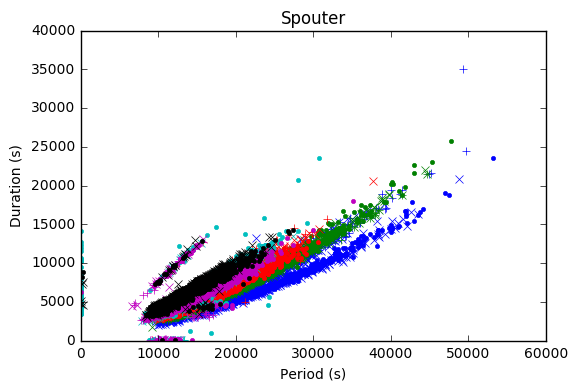

In [339]:
xmin=0
xmax=60000
plt.plot(period0,duration0,'b.',period1,duration1,'bx',period2,duration2,'b+',
         period3,duration3,'g.',period4,duration4,'gx',period5,duration5,'g+',
        period6,duration6,'r.',period7,duration7,'rx',period8,duration8,'r+',
        period9,duration9,'c.',period10,duration10,'cx',period11,duration11,'c+',
        period12,duration12,'m.',period13,duration13,'mx',period14,duration14,'m+',
        period15,duration15,'k.',period16,duration16,'kx',period17,duration17,'k+')
#pylab.ylim([0,2000])
pylab.xlim([xmin,xmax])
pylab.xlabel('Period (s)')
pylab.ylabel('Duration (s)')
pylab.title(name)
plt.show()

In [340]:
name='Plate'
period0,duration0=get_period_duration(df0,name)
period1,duration1=get_period_duration(df1,name)
period2,duration2=get_period_duration(df2,name)
period3,duration3=get_period_duration(df3,name)
period4,duration4=get_period_duration(df4,name)
period5,duration5=get_period_duration(df5,name)
period6,duration6=get_period_duration(df6,name)
period7,duration7=get_period_duration(df7,name)
period8,duration8=get_period_duration(df8,name)
period9,duration9=get_period_duration(df9,name)
period10,duration10=get_period_duration(df10,name)
period11,duration11=get_period_duration(df11,name)
period12,duration12=get_period_duration(df12,name)
period13,duration13=get_period_duration(df13,name)
period14,duration14=get_period_duration(df14,name)
period15,duration15=get_period_duration(df15,name)
period16,duration16=get_period_duration(df16,name)
period17,duration17=get_period_duration(df17,name)


/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Not enough data for geyser Plate
Not enough data for geyser Plate
Not enough data for geyser Plate
Not enough data for geyser Plate


/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


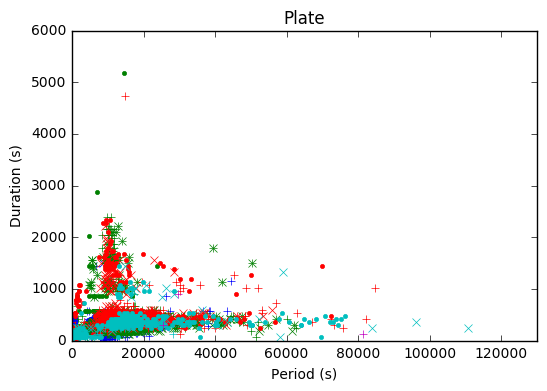

In [341]:
xmin=0
xmax=130000
plt.plot(period0,duration0,'b.',period1,duration1,'bx',period2,duration2,'b+',
         period3,duration3,'g.',period4,duration4,'gx',period5,duration5,'g+',
        period6,duration6,'r.',period7,duration7,'rx',period8,duration8,'r+',
        period9,duration9,'c.',period10,duration10,'cx',period11,duration11,'c+',
        period12,duration12,'m.',period13,duration13,'mx',period14,duration14,'m+',
        period15,duration15,'k.',period16,duration16,'kx',period17,duration17,'k+')
#pylab.ylim([0,2000])
pylab.xlim([xmin,xmax])
pylab.xlabel('Period (s)')
pylab.ylabel('Duration (s)')
pylab.title(name)
plt.show()

In [342]:
name='Rift'
period0,duration0=get_period_duration(df0,name)
period1,duration1=get_period_duration(df1,name)
period2,duration2=get_period_duration(df2,name)
period3,duration3=get_period_duration(df3,name)
period4,duration4=get_period_duration(df4,name)
period5,duration5=get_period_duration(df5,name)
period6,duration6=get_period_duration(df6,name)
period7,duration7=get_period_duration(df7,name)
period8,duration8=get_period_duration(df8,name)
period9,duration9=get_period_duration(df9,name)
period10,duration10=get_period_duration(df10,name)
period11,duration11=get_period_duration(df11,name)
period12,duration12=get_period_duration(df12,name)
period13,duration13=get_period_duration(df13,name)
period14,duration14=get_period_duration(df14,name)
period15,duration15=get_period_duration(df15,name)
period16,duration16=get_period_duration(df16,name)
period17,duration17=get_period_duration(df17,name)


/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Not enough data for geyser Rift
Not enough data for geyser Rift


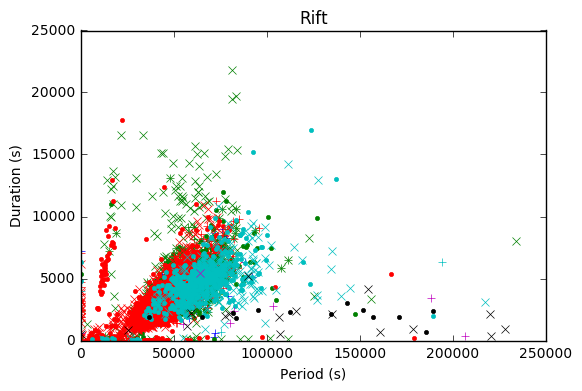

In [343]:
xmin=0
xmax=250000
plt.plot(period0,duration0,'b.',period1,duration1,'bx',period2,duration2,'b+',
         period3,duration3,'g.',period4,duration4,'gx',period5,duration5,'g+',
        period6,duration6,'r.',period7,duration7,'rx',period8,duration8,'r+',
        period9,duration9,'c.',period10,duration10,'cx',period11,duration11,'c+',
        period12,duration12,'m.',period13,duration13,'mx',period14,duration14,'m+',
        period15,duration15,'k.',period16,duration16,'kx',period17,duration17,'k+')
#pylab.ylim([0,2000])
pylab.xlim([xmin,xmax])
pylab.xlabel('Period (s)')
pylab.ylabel('Duration (s)')
pylab.title(name)
plt.show()

In [344]:
name='Sawmill'
period0,duration0=get_period_duration(df0,name)
period1,duration1=get_period_duration(df1,name)
period2,duration2=get_period_duration(df2,name)
period3,duration3=get_period_duration(df3,name)
period4,duration4=get_period_duration(df4,name)
period5,duration5=get_period_duration(df5,name)
period6,duration6=get_period_duration(df6,name)
period7,duration7=get_period_duration(df7,name)
period8,duration8=get_period_duration(df8,name)
period9,duration9=get_period_duration(df9,name)
period10,duration10=get_period_duration(df10,name)
period11,duration11=get_period_duration(df11,name)
period12,duration12=get_period_duration(df12,name)
period13,duration13=get_period_duration(df13,name)
period14,duration14=get_period_duration(df14,name)
period15,duration15=get_period_duration(df15,name)
period16,duration16=get_period_duration(df16,name)
period17,duration17=get_period_duration(df17,name)


/home/azalucha/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/azalucha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Not enough data for geyser Sawmill
Not enough data for geyser Sawmill
Not enough data for geyser Sawmill
Not enough data for geyser Sawmill
Not enough data for geyser Sawmill
Not enough data for geyser Sawmill
Not enough data for geyser Sawmill


/home/azalucha/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


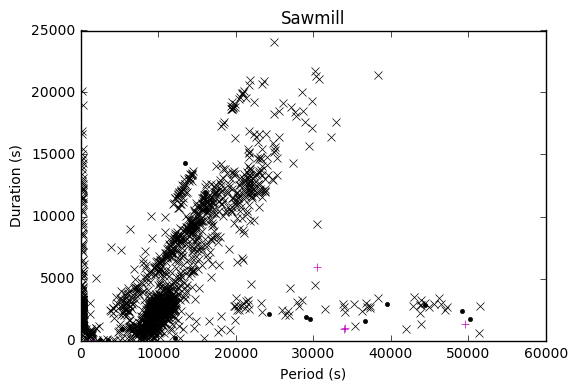

In [345]:
xmin=0
xmax=60000
plt.plot(period0,duration0,'b.',period1,duration1,'bx',period2,duration2,'b+',
         period3,duration3,'g.',period4,duration4,'gx',period5,duration5,'g+',
        period6,duration6,'r.',period7,duration7,'rx',period8,duration8,'r+',
        period9,duration9,'c.',period10,duration10,'cx',period11,duration11,'c+',
        period12,duration12,'m.',period13,duration13,'mx',period14,duration14,'m+',
        period15,duration15,'k.',period16,duration16,'kx',period17,duration17,'k+')
#pylab.ylim([0,2000])
pylab.xlim([xmin,xmax])
pylab.xlabel('Period (s)')
pylab.ylabel('Duration (s)')
pylab.title(name)
plt.show()